# <ins> DM&ML Portfolio

## <ins> Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
# Libraries required for data preprocessing

# min-max scaling for scaling
from sklearn.preprocessing import MinMaxScaler
# smote for oversampling
from imblearn.over_sampling import SMOTE
# data shuffling
from sklearn.utils import shuffle

In [3]:
# libraries required for training and running the classifiers
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

---

## <ins> Intializing Classifiers

In [4]:
multNB = MultinomialNB()
GNB = GaussianNB()
compNB = ComplementNB()
bernNB = BernoulliNB()
catNB = CategoricalNB()

---

## <ins> Load the Data

In [5]:
X_train, y_train = pd.read_csv('CompleteDataSet/x_train_all.csv'), pd.read_csv('CompleteDataSet/y_train_all.csv')

In [6]:
# renaming the column name in y_train from '0' to 'label'
y_train.rename(columns={'0':'label'}, inplace=True)

---

## <ins> Dataset Summary and Exploration ##

<ins> **Dataset description**

The data set used is the German Traffic Sign dataset which is a subset of the computer vision benchmark data set  “German Street Sign Recognition Benchmark by Stallkamp et al”.

We will be working with a sample of this data set which consists of 10 classes and 9690 images. The images have been converted to grey-scale with pixel values ranging from 0 to 255 and were rescaled to a common size of 48*48 pixels. Hence, each row (= feature vector) in the data set has 2305 features and represents a single image in row-vector format (2304 features) plus its associated class label.

<ins>The 10 classes are: </ins>

Class label - Traffic Sign

- 0 - speed limit 20

- 1 - speed limit 30

- 2 - speed limit 50

- 3 - speed limit 60

- 4 - speed limit 70

- 5 - left turn

- 6 - right turn

- 7 - beware pedestrian crossing

- 8 - beware children

- 9 - beware cycle route ahead

---

## <ins> Size of the data

In [7]:
X_train.shape

(9690, 2304)

In [8]:
y_train.shape

(9690, 1)

- size of our train set is 9690, which is approximately 75.8% of the total data (12,780)

- The dataframes store the data in the following format:

    - X_train: 2304 features (48x48 pixel values of an image) = 2304 columns, 9690 rows

    - y_train: 1 column (class labels), 9690 rows

---

## <ins>Data Preprocessing <ins>

### <ins> Checking for missing values

In [9]:
# checking if there are any missing values in the dataset
print('Number of missing values in X_train: ' , X_train.isnull().sum().sum())

print('Number of missing values in y_train: ' , y_train.isnull().sum().sum())

Number of missing values in X_train:  0
Number of missing values in y_train:  0


It is observed that both the input features (X_train) and the target values (y_train) have no missing values, indicating a complete and clean dataset suitable for analysis and modeling without the need for handling missing data

---

### <ins> Checking for outliers

In [10]:
# checking for outliers in the dataset (any values outside range of [0-255])
print('Number of values in X_train <0 : ' , (X_train < 0).sum().sum())
print('Number of values in X_train >255 : ' , (X_train > 255).sum().sum())

Number of values in X_train <0 :  0
Number of values in X_train >255 :  0


We can observe that there is no outliers in our data i.e. all data points are well within the expected range.

---

### <ins> Checking for errors

In [11]:
# checking if all values are of type int64 values in the dataset
print('data types of values in X_train: ' , X_train.dtypes.value_counts())

data types of values in X_train:  float64    2304
dtype: int64


- we only have numerical data in our data set, hence there are no errors in the data

---

## <ins> Data Scaling ###

In [12]:
# scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

---

## <ins> Data Visualization

### <ins> Plotting average values of each feature for each label

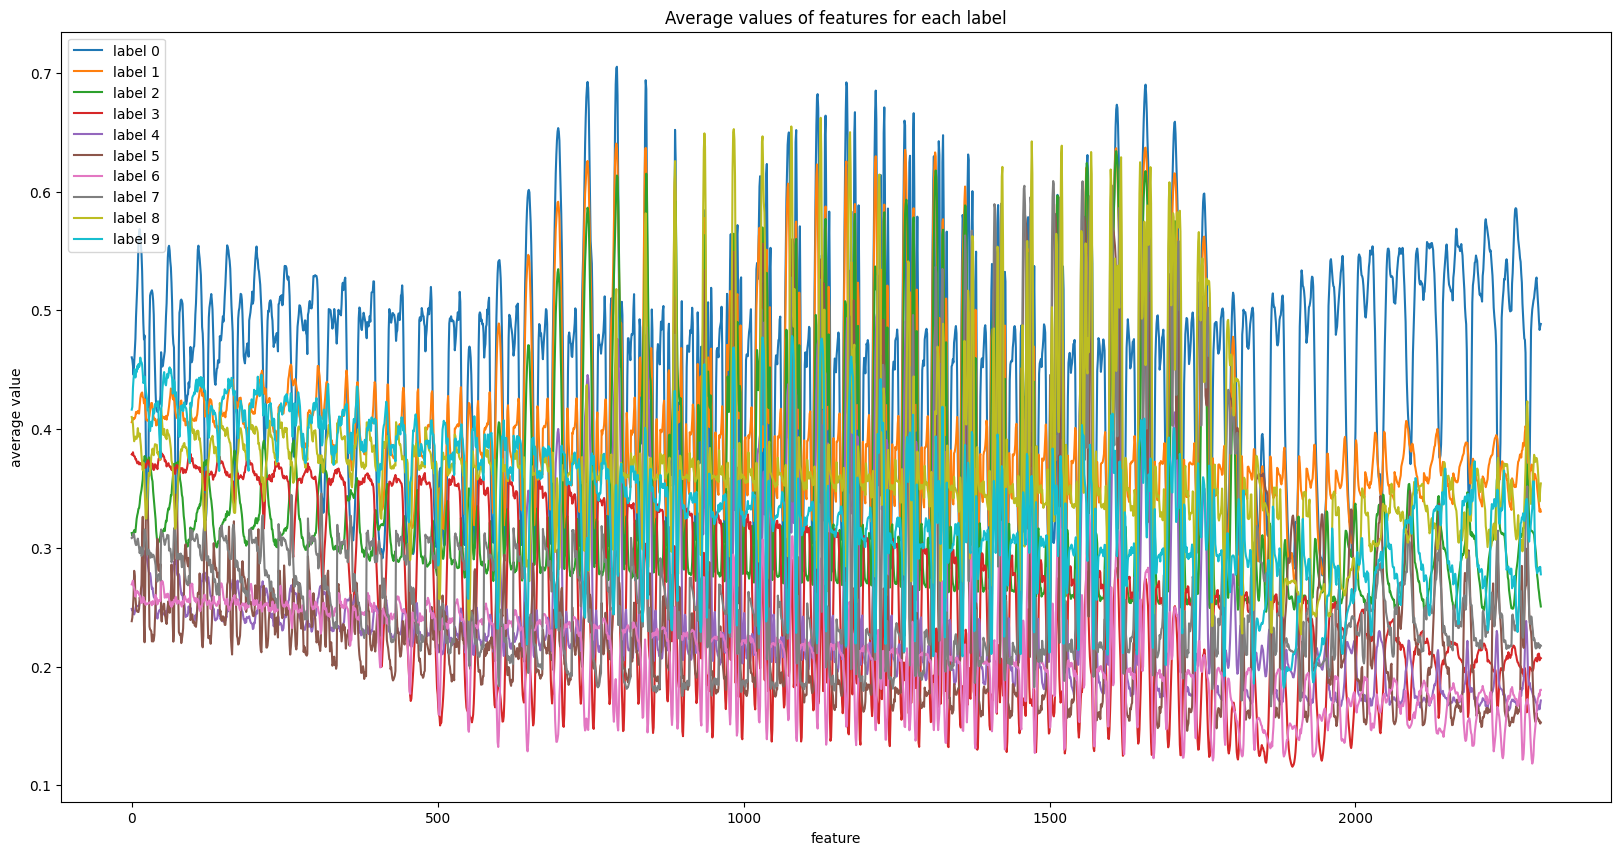

In [13]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(X_train_scaled[y_train['label'] == i].mean(axis=0), label='label {}'.format(i))
plt.legend()
plt.xlabel('feature')
plt.ylabel('average value')
plt.title('Average values of features for each label')
plt.show()

---

### <ins> Plotting the distribution for the labels

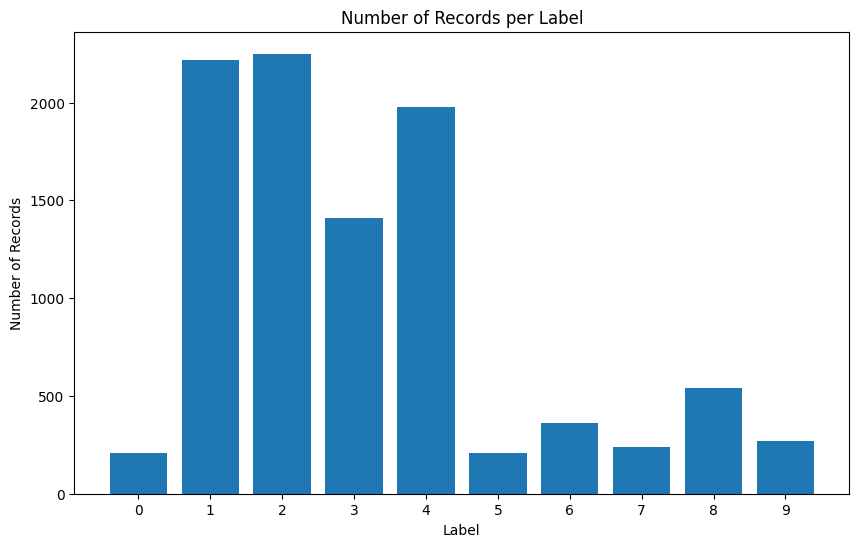

In [14]:
target_counts = y_train['label'].value_counts()

# Sort the counts by index (label) for better visualization
target_counts = target_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(target_counts.index, target_counts.values)

# Set explicit tick locations and labels
plt.xticks(target_counts.index)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Number of Records')
plt.title('Number of Records per Label')

# Show the plot
plt.show()

- Minority classes : 0,5,6,7,8,9

- Majority classes : 1,2,3,4

From the above plot, we can observe that the dataset is imbalanced, i.e, each class does not have the same number of samples.

---

<ins>Oversampling (for imbalanced data)

*  Oversampling can reduce the bias that the model may have towards the majority class in imbalanced datasets.
*  Oversampling the minority class can lead to an improvement in evaluation metrics, especially if the original dataset had a severe class imbalance problem.
* It helps the model learn from more balanced data, potentially resulting in higher accuracy, precision, recall, F1-score, and a better ROC AUC score.



---

## <ins> Helper functions for :
- plotting ROC curve
- plotting confusion matrix
- printing the metrics class-wise and overall.

In [15]:
# Helper function to plot ROC curves
def plot_roc_for_classes(true_bin_labels, score, classes, title="ROC Curve"):
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_bin_labels[:, i], score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Helper function to find specificity
def specificity(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    specificity = TN/(TN+FP)
    return np.mean(specificity)

# Helper functions to print overall metrics
def print_overall_metrics(true_labels, pred_labels):
    acc = accuracy_score(true_labels, pred_labels)
    presc = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    rec = recall_score(true_labels, pred_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=1)
    tpr = rec
    # Calculate FPR correctly using roc_curve
    s = specificity(confusion_matrix(true_labels, pred_labels))
    fpr = 1 - s

    print('Accuracy:', acc)
    print('Precision:', presc)
    print('Recall (TPR):', tpr)
    print('False Positive Rate (FPR):', fpr)
    print('F1 score (F-measure):', f1)
    print('Specificity:', s)
    print("------------------------------------------------------------------------------------------------")

# Helper functions to print class-wise metrics
def get_classwise_metrics_dataframe(true_labels, pred_labels, unique_labels):
    metrics_data = []
    matrix = confusion_matrix(true_labels, pred_labels, labels=unique_labels)

    for i, label in enumerate(unique_labels):
        tp = matrix[i, i]
        fp = np.sum(matrix[:, i]) - tp
        fn = np.sum(matrix[i, :]) - tp
        tn = np.sum(matrix) - tp - fp - fn

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tpr
        f_measure = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        metrics_data.append([label, accuracy, precision, recall, fpr, f_measure, tp, fp, tn, fn])

    df = pd.DataFrame(metrics_data, columns=['Class', 'Accuracy', 'Precision', 'Recall (TPR)', 'FPR', 'F1 Score (F-measure)', 'TP', 'FP', 'TN', 'FN'])

    return df

# Helper function to plot confusion matrix
def plot_confusion_matrix(matrix, dataset_name, unique_labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks + 0.5, unique_labels, rotation=45)  # +0.5 to center the label
    plt.yticks(tick_marks + 0.5, unique_labels)  # +0.5 to center the label
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix')
    plt.show()

## <ins> Function for running a classifier with a dataset

In [16]:
def runclassifier(model, data):
    
    labels_series = data['label']
    unique_labels = sorted(labels_series.unique())
    X_train = data.drop('label', axis=1)
    y_train = data['label']

    # Binarize the labels for ROC curve generation
    y_train_bin = label_binarize(y_train, classes=unique_labels)

    model.fit(X_train, y_train)
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)

    # Overall metrics for training set
    print("Overall Metrics")
    print("------------------------------------------------------------------------------------------------")
    print_overall_metrics(y_train, y_train_pred)

    # Display metrics in tabular format for each class
    classwise_df_train = get_classwise_metrics_dataframe(y_train, y_train_pred, unique_labels)
    print("\nClasswise Metrics:")
    display(classwise_df_train)

    print("------------------------------------------------------------------------------------------------")
    print("Confusion Matrix")
    print("------------------------------------------------------------------------------------------------")
    plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), 'Training Set', unique_labels)
    print("------------------------------------------------------------------------------------------------")
    print("ROC Curve")
    print("------------------------------------------------------------------------------------------------")
    plot_roc_for_classes(y_train_bin, model.predict_proba(X_train), unique_labels, title="ROC Curve")
    print("------------------------------------------------------------------------------------------------")


    # Create metrics dictionary
    metrics_dict = {
        "Model": model.__class__.__name__,
        "Training Metrics": {
            "Accuracy": accuracy_score(y_train, y_train_pred),
            "Precision": precision_score(y_train, y_train_pred, average='weighted',zero_division=0),
            "Recall": recall_score(y_train, y_train_pred, average='weighted'),
            "F1 score": f1_score(y_train, y_train_pred, average='weighted'),
            "TP": np.diag(confusion_matrix(y_train, y_train_pred)),
            "FP": confusion_matrix(y_train, y_train_pred).sum(axis=0) - np.diag(confusion_matrix(y_train, y_train_pred)),
            "TN": confusion_matrix(y_train, y_train_pred).sum() - (confusion_matrix(y_train, y_train_pred).sum(axis=1) + confusion_matrix(y_train, y_train_pred).sum(axis=0)- np.diag(confusion_matrix(y_train, y_train_pred))),
            "FN": confusion_matrix(y_train, y_train_pred).sum(axis=1)-np.diag(confusion_matrix(y_train, y_train_pred)),
            "Sensitivity (TPR)": recall_score(y_train, y_train_pred, average='weighted'),
            "Specificity": specificity(confusion_matrix(y_train, y_train_pred)),
            "FPR": 1 - specificity(confusion_matrix(y_train, y_train_pred))
        },
    }

    return metrics_dict # returns the overall metrics back

---

### <ins> Performance with imbalanced data

In [17]:
X_new = pd.DataFrame(X_train_scaled)  # Replace 'target_column' with the name of your target column
#y_new = pd.DataFrame(y_train, columns=['label'])
print('Before OverSampling, the shape of train_X: {}'.format(X_new.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

Before OverSampling, the shape of train_X: (9690, 2304)
Before OverSampling, the shape of train_y: (9690, 1) 



- <ins> Initializing and running Gaussian Naive Bayes classifier :

Gaussian:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.1865841073271414
Precision: 0.31428768787223355
Recall (TPR): 0.1865841073271414
False Positive Rate (FPR): 0.08955982596584722
F1 score (F-measure): 0.20479037406867057
Specificity: 0.9104401740341528
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.902270   0.111697      0.504762  0.088924              0.182916   
1      1  0.730237   0.343651      0.195045  0.110710              0.248851   
2      2  0.737977   0.348691      0.148000  0.083602              0.207800   
3      3  0.842312   0.416193      0.207801  0.049638              0.277200   
4      4  0.768731   0.300763      0.099495  0.059403              0.149526   
5      5  0.924458   0.037234      0.100000  0.057278              0.054264   
6      6  0.728070   0.081955      0.619444  0.267738              0.144758   
7      7  0.848194   0.060671      0.354167  0.139259              0.103595   
8      8  0.938803   0.370732      0.140741  0.014098              0.204027   
9      9  0.952116   0.148551      0.151852  0.024947              0.150183   

    TP    FP    TN    FN  
0  106   843  8637   104  
1  433   827  6643  1787  
2  333   622  6818  1917  
3  293   411  7869  1117  
4  197   458  7252  1783  
5   21   543  8937   189  
6  223  2498  6832   137  
7   85  1316  8134   155  
8   76   129  9021   464  
9   41   235  9185   229

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


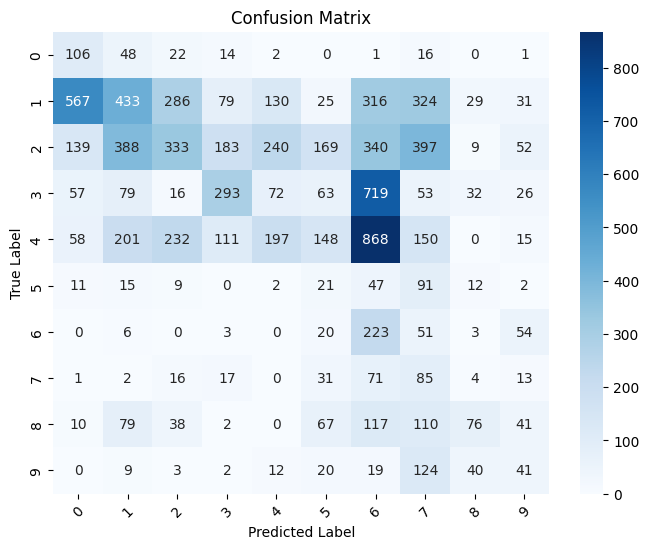

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


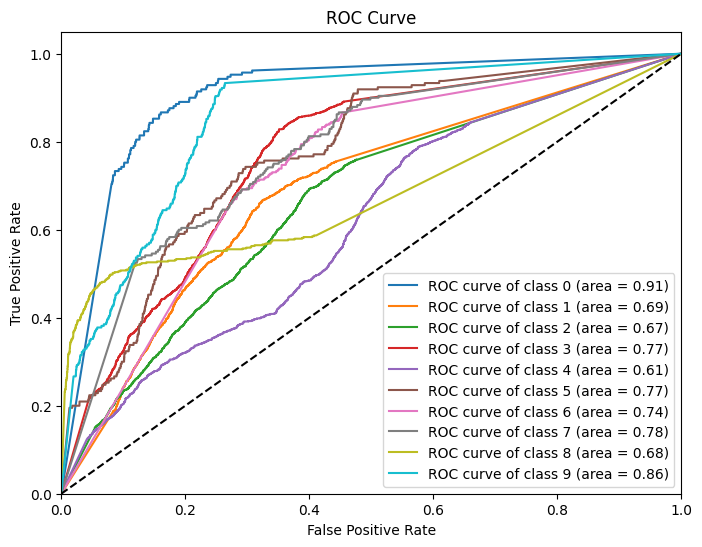

------------------------------------------------------------------------------------------------


In [18]:
gnb = GaussianNB()
print("Gaussian:")
print("------------------------------------------------------------------------------------------------")
dataset = pd.concat([X_new, y_train], axis=1)
gnb_result = runclassifier(gnb,dataset)

Observing the classification report, we can tell the support for each class varies due to imbalance of samples across each class.

The above results indicates that the model performs *well on the majority class* but *poorly on the minority classes*.

---

## <ins> Using SMOTE to balance the data ###

In [19]:
# Separate your features (X) and target variable (y)
X = pd.DataFrame(X_train_scaled)  # Replace 'target_column' with the name of your target column
y = pd.DataFrame(y_train, columns=['label'])

# Initialize the SMOTE object
smote = SMOTE(random_state=42)  # You can specify different options if needed

# Apply SMOTE to generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X, y)

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_resampled.shape))

# Convert the result to a combined Pandas data frame
balanced_data_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

After OverSampling, the shape of train_X: (22500, 2304)
After OverSampling, the shape of train_y: (22500, 1) 



---

### <ins> Plotting the balanced data

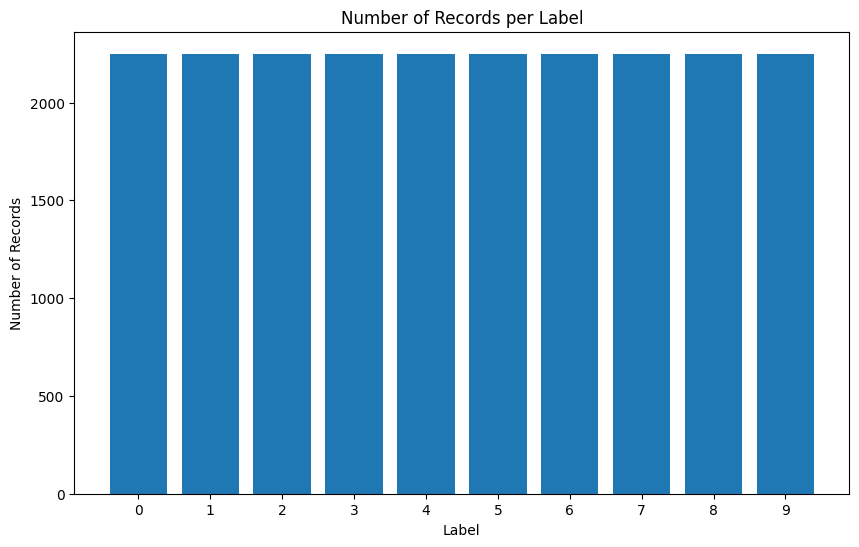

In [20]:
### plotting the distribution of the labels after resampling
target_counts = balanced_data_df['label'].value_counts()

# Sort the counts by index (label) for better visualization
target_counts = target_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(target_counts.index, target_counts.values)

# Set explicit tick locations and labels
plt.xticks(target_counts.index)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Number of Records')
plt.title('Number of Records per Label')

# Show the plot
plt.show()

---

## <ins> Running the Gaussian Naive Bayes classifier on the balanced dataset

Gaussian:
Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.34346666666666664
Precision: 0.3886412206755476
Recall (TPR): 0.34346666666666664
False Positive Rate (FPR): 0.07294814814814798
F1 score (F-measure): 0.3254606282203863
Specificity: 0.927051851851852
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.925511   0.607250      0.722222  0.051901              0.659765   
1      1  0.872800   0.313642      0.228889  0.055654              0.264645   
2      2  0.874267   0.251502      0.130222  0.043062              0.171596   
3      3  0.894356   0.441475      0.212889  0.029926              0.287256   
4      4  0.886533   0.276219      0.083111  0.024198              0.127776   
5      5  0.856800   0.308511      0.348000  0.086667              0.327068   
6      6  0.759156   0.239349      0.646667  0.228346              0.349382   
7      7  0.808889   0.271817      0.542667  0.161531              0.362207   
8      8  0.914622   0.724420      0.236000  0.009975              0.356017   
9      9  0.894000   0.452229      0.284000  0.038222              0.348894   

     TP    FP     TN    FN  
0  1625  1051  19199   625  
1   515  1127  19123  1735  
2   293   872  19378  1957  
3   479   606  19644  1771  
4   187   490  19760  2063  
5   783  1755  18495  1467  
6  1455  4624  15626   795  
7  1221  3271  16979  1029  
8   531   202  20048  1719  
9   639   774  19476  1611

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


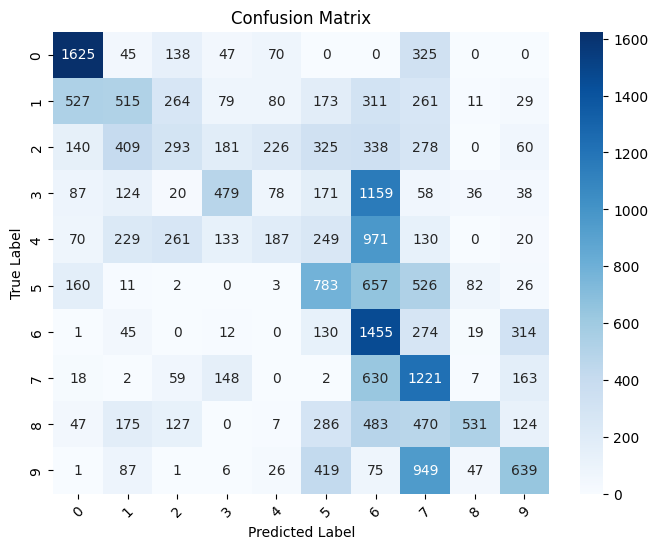

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


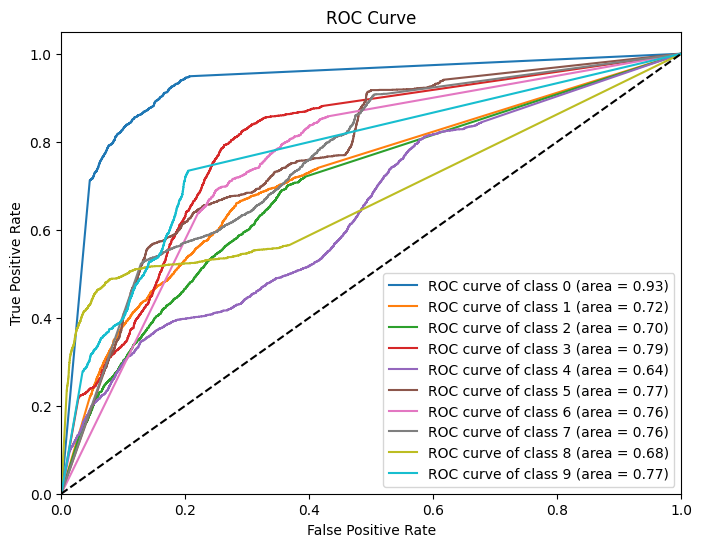

------------------------------------------------------------------------------------------------


In [21]:
print("Gaussian:")
gnb_result = runclassifier(GNB,balanced_data_df)

Compared to the previous results before oversampling, the overall *F1-score of the model has improved from 0.2 to 0.32* .

We can also observe that the support value for each class is the same, indicating balanced number of samples across each class.

---

## <ins> Data Shuffling

Data was originally found to be ordered. To reduce bias while training, we shuffled the dataset.

In [22]:
shuffled_balanced_data_df = shuffle(balanced_data_df, random_state=0)

---

### <ins> Separate dataframe for attributes and labels

In [23]:
attributes_df = shuffled_balanced_data_df.drop('label', axis=1)  # Replace 'target_column' with the name of your target column
labels_df = shuffled_balanced_data_df['label']

### <ins> numpy array forms for attributes and labels

In [24]:
# converting labels to numpy array
labels = labels_df.to_numpy()

# converting attributes_df to numpy array
attributes = attributes_df.to_numpy()

 - The dataframe with shuffled and balanced data (original) is : shuffled_balanced_data_df
 - The attributes dataframe for the original dataframe is : attributes_df
 - The labels dataframe for the original dataframe is : labels_df


---

## <ins> Functions </ins>

### <ins> Function for plotting an image ###

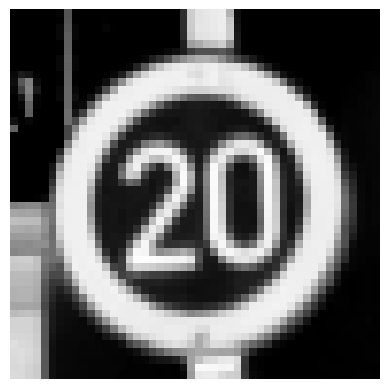

Label:  0


In [25]:
def plot_digit(image_data):
    image = image_data.reshape(48, 48)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

image_index = 153
some_digit = attributes[image_index]
plot_digit(some_digit)
plt.show()
print("Label: ", labels[image_index])

---

### <ins> Function for plotting multiple images ###

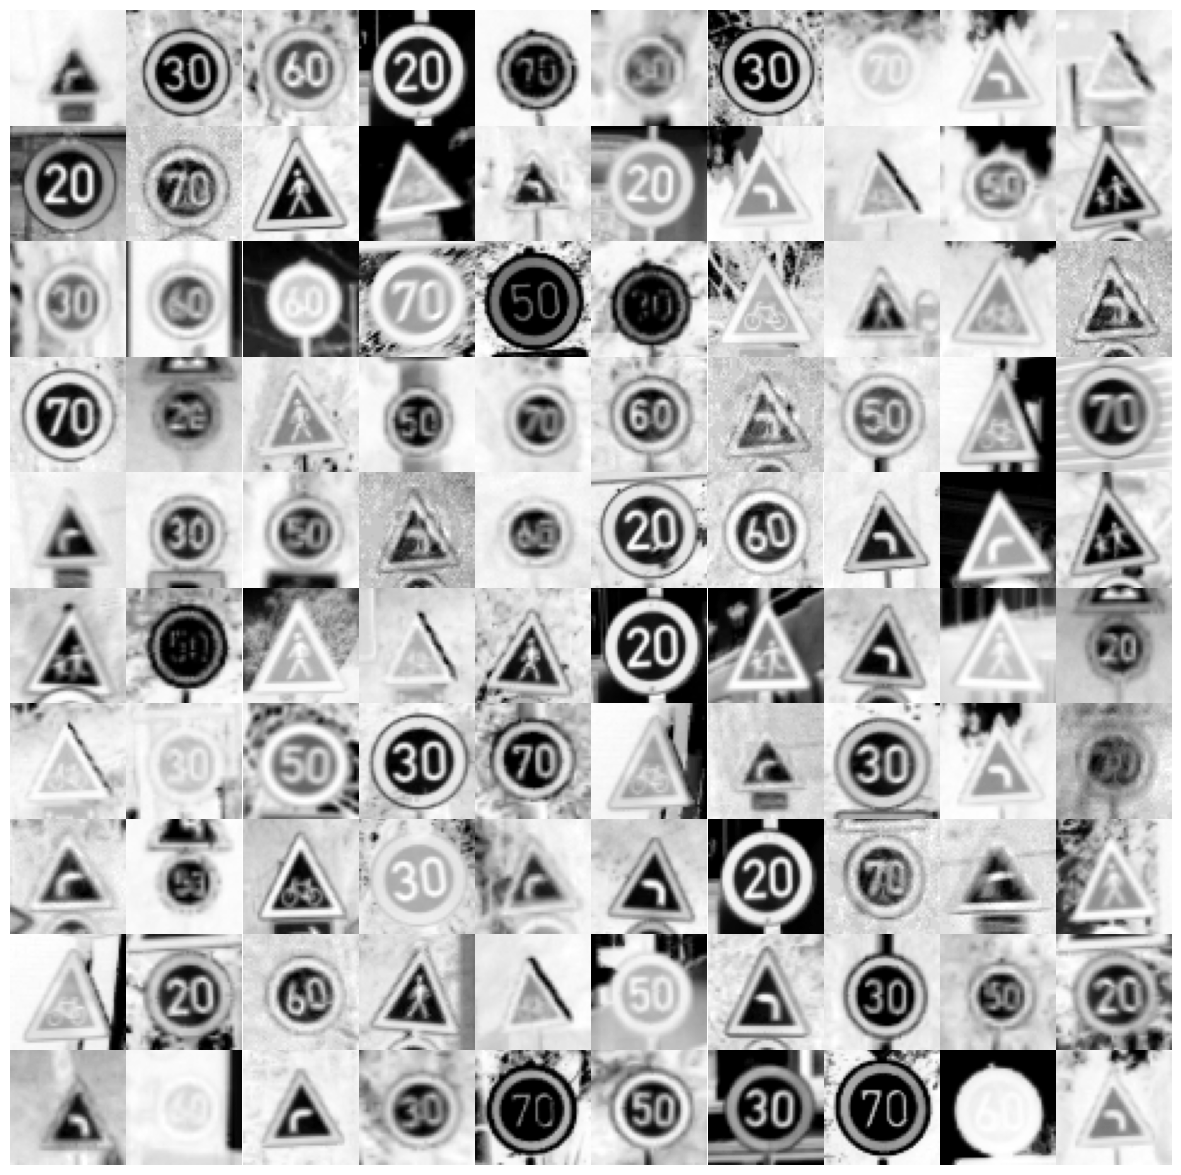

In [26]:
plt.figure(figsize=(15, 15))

def plot_digits(start,end):
    for idx, image_data in enumerate(attributes[start:end]):
        plt.subplot(10, 10, idx + 1)
        plot_digit(image_data)

plt.subplots_adjust(wspace=0, hspace=0)
plot_digits(150,250)
plt.show()

---

### <ins>Training KNN classifier on the original dataset</ins> ###

#### KNN classifier was used to set a baseline performance of an alternate classifier for our dataset.

K-Nearest Neighbours:
Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.9614222222222222
Precision: 0.9613096583682798
Recall (TPR): 0.9614222222222222
False Positive Rate (FPR): 0.004286419753086412
F1 score (F-measure): 0.9611291382339782
Specificity: 0.9957135802469136
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.994400   0.946970      1.000000  0.006222              0.972763   
1      1  0.981111   0.914208      0.895111  0.009333              0.904559   
2      2  0.981156   0.928638      0.879111  0.007506              0.903196   
3      3  0.984667   0.907225      0.943111  0.010716              0.924820   
4      4  0.985200   0.945607      0.904000  0.005778              0.924335   
5      5  0.999467   0.994695      1.000000  0.000593              0.997340   
6      6  0.998311   0.985514      0.997778  0.001630              0.991608   
7      7  0.999600   0.996016      1.000000  0.000444              0.998004   
8      8  0.999244   0.996885      0.995556  0.000346              0.996220   
9      9  0.999689   0.997339      0.999556  0.000296              0.998446   

     TP   FP     TN   FN  
0  2250  126  20124    0  
1  2014  189  20061  236  
2  1978  152  20098  272  
3  2122  217  20033  128  
4  2034  117  20133  216  
5  2250   12  20238    0  
6  2245   33  20217    5  
7  2250    9  20241    0  
8  2240    7  20243   10  
9  2249    6  20244    1

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


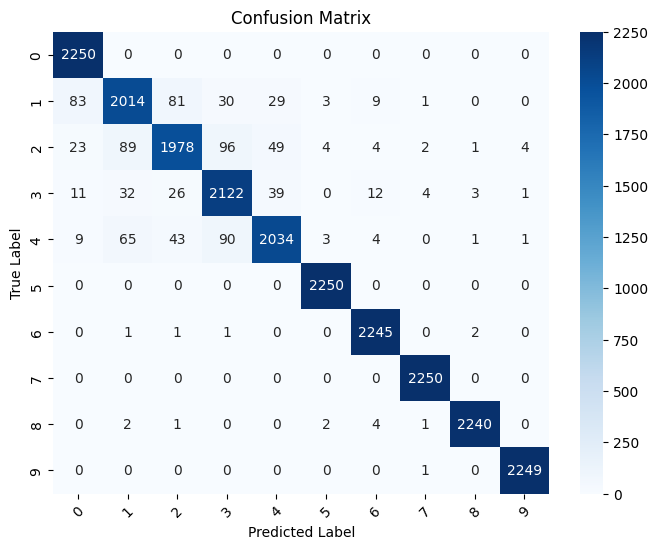

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


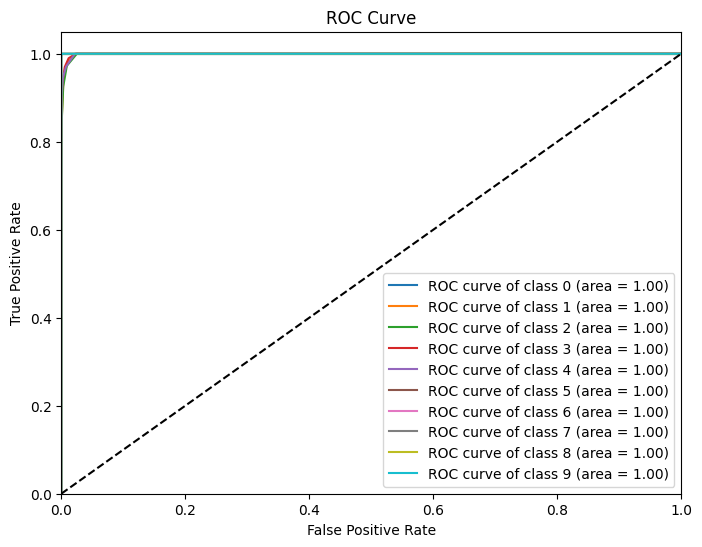

------------------------------------------------------------------------------------------------


In [27]:
### training KNN classifier

knn = KNeighborsClassifier(n_neighbors=5)
print("K-Nearest Neighbours:")
knn_result = runclassifier(knn,shuffled_balanced_data_df)

---

## <ins> PCA reduced dataset (dimensionality reduction) ##

PCA is implemented here to reduce the dimensionality of data while preserving as much of the data's variance as possible.

In [28]:
balanced_data_copy_df = balanced_data_df.copy()  # making a copy of the unshuffled data

# attributes
attributes_copy_df = balanced_data_copy_df.drop('label', axis=1)
#labels
labels_copy_df = balanced_data_copy_df['label']

### <ins> Finding optimal number of components

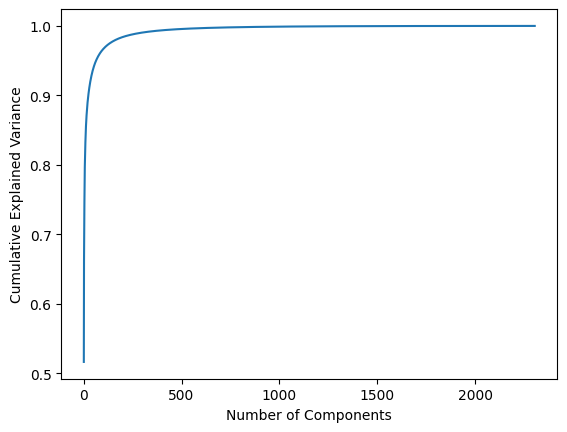

In [29]:
# PCA for finding optimal number of components to be used
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(attributes_copy_df)
# calculates the explained variance ratio for each principal component
# this ratio represents the proportion of total variance in the data explained by each component.
explained_variance = pca.explained_variance_ratio_
# ndicates how much of the total variance is explained as more and more components are included in the analysis.
cumulative_explained_variance = explained_variance.cumsum()

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

The elbow point is where the explained variance begins to level off, indicating that adding more components doesn't provide much additional information.

In the above plot, we can see the curve start to level off when the number of components reaches 200. Hence, we're choosing **200 components for PCA**


---

### <ins> Transforming the data

In [30]:
# PCA with 200 components
pca = PCA(n_components=200)
pca.fit(attributes_copy_df)
attributes_copy_pca = pca.transform(attributes_copy_df)

# converting scaled_data_attributes_pca to dataframe
attributes_copy_pca_df = pd.DataFrame(attributes_copy_pca)

---

### <ins> Adding the labels to the transformed data

In [31]:
# adding the labels column to attributes_copy_pca_df
pca_data_with_labels = pd.concat([attributes_copy_pca_df, labels_df], axis=1)

### <ins> Shuffling the PCA dataframe

In [32]:
# shuffling
shuffled_pca_data_with_labels = shuffle(pca_data_with_labels, random_state=0)

In [33]:
# attributes of pca data
pca_attributes_df = shuffled_pca_data_with_labels.drop('label', axis=1)
# labels of pca data
pca_labels_df = shuffled_pca_data_with_labels['label']

---

## <ins> Running Gaussian Naive Bayes classifier on the PCA reduced dataset

Gaussian:


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.4189777777777778
Precision: 0.6109801122132864
Recall (TPR): 0.4189777777777778
False Positive Rate (FPR): 0.06455802469135796
F1 score (F-measure): 0.43950835842802594
Specificity: 0.935441975308642
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.934978   0.834325      0.436444  0.009630              0.573096   
1      1  0.797867   0.258207      0.545333  0.174074              0.350471   
2      2  0.908667   0.611684      0.237333  0.016741              0.341979   
3      3  0.855644   0.275428      0.272000  0.079506              0.273703   
4      4  0.901689   0.518340      0.238667  0.024642              0.326841   
5      5  0.927511   0.757702      0.404444  0.014370              0.527383   
6      6  0.707556   0.234486      0.849778  0.308247              0.367551   
7      7  0.946533   0.923887      0.507111  0.004642              0.654806   
8      8  0.935867   0.856134      0.431111  0.008049              0.573456   
9      9  0.921644   0.839609      0.267556  0.005679              0.405797   

     TP    FP     TN    FN  
0   982   195  20055  1268  
1  1227  3525  16725  1023  
2   534   339  19911  1716  
3   612  1610  18640  1638  
4   537   499  19751  1713  
5   910   291  19959  1340  
6  1912  6242  14008   338  
7  1141    94  20156  1109  
8   970   163  20087  1280  
9   602   115  20135  1648

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


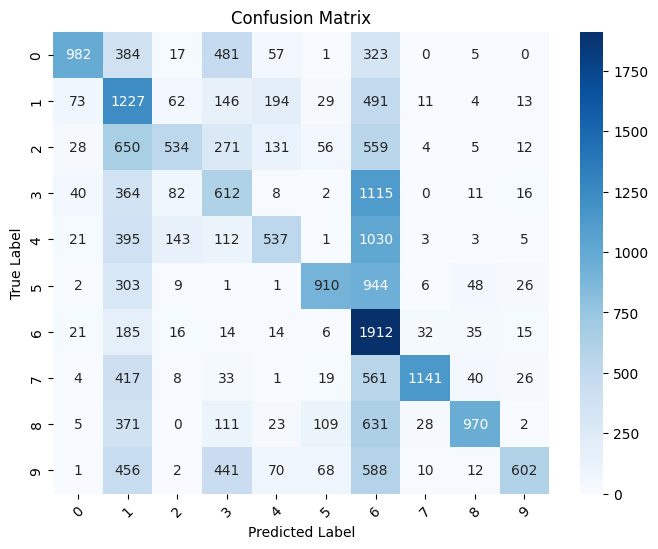

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


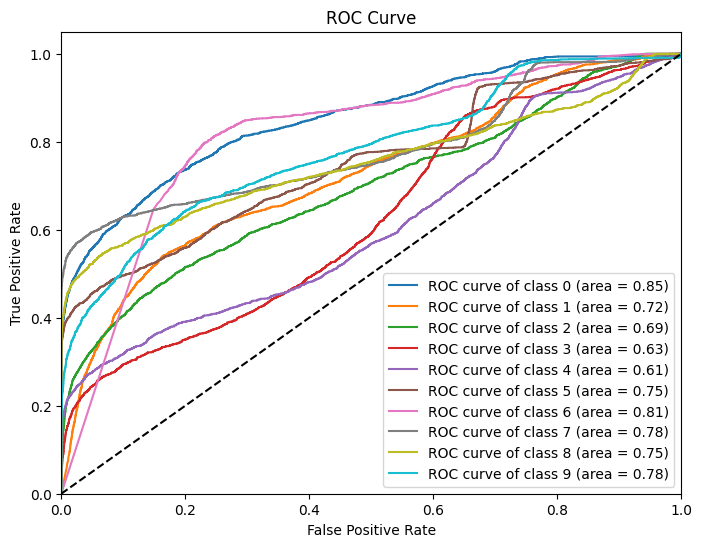

------------------------------------------------------------------------------------------------


In [34]:
gnb_pca = GaussianNB()
print("Gaussian:")
gnb_pca_result = runclassifier(gnb_pca,shuffled_pca_data_with_labels)

- We can observe that the performance of GNB is better on the PCA reduced dataset (F1 - 0.44) than the original dataset (F1 - 0.32).

---

## <ins> Running various classifiers on the pre-processed original dataset

### 1. <ins> Multinomial Naive Bayes

Multinomial:
Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.3715111111111111
Precision: 0.38193139301624784
Recall (TPR): 0.3715111111111111
False Positive Rate (FPR): 0.06983209876543195
F1 score (F-measure): 0.35220681543305765
Specificity: 0.930167901234568
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.905156   0.531798      0.431111  0.042173              0.476190   
1      1  0.868489   0.257358      0.167111  0.053580              0.202641   
2      2  0.860133   0.295672      0.288444  0.076346              0.292013   
3      3  0.843511   0.289081      0.387111  0.105778              0.330990   
4      4  0.856800   0.376462      0.658222  0.121136              0.478978   
5      5  0.835422   0.351158      0.761778  0.156395              0.480718   
6      6  0.887289   0.314286      0.107556  0.026074              0.160265   
7      7  0.891156   0.445058      0.358222  0.049630              0.396947   
8      8  0.894756   0.455706      0.269778  0.035802              0.338917   
9      9  0.900311   0.502737      0.285778  0.031407              0.364409   

     TP    FP     TN    FN  
0   970   854  19396  1280  
1   376  1085  19165  1874  
2   649  1546  18704  1601  
3   871  2142  18108  1379  
4  1481  2453  17797   769  
5  1714  3167  17083   536  
6   242   528  19722  2008  
7   806  1005  19245  1444  
8   607   725  19525  1643  
9   643   636  19614  1607

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


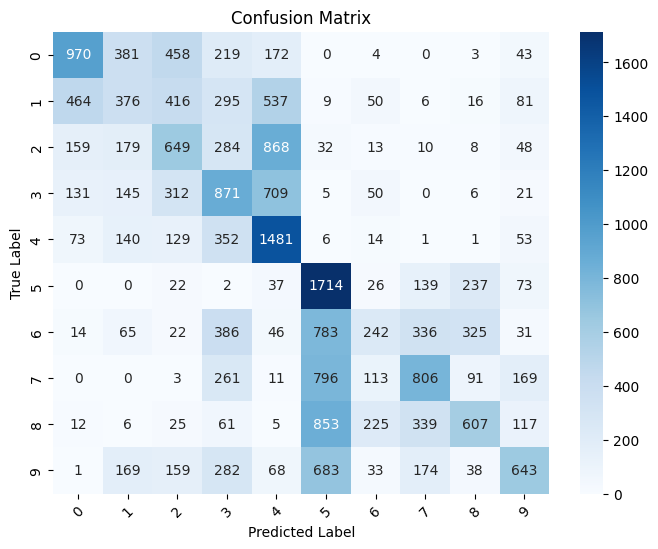

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


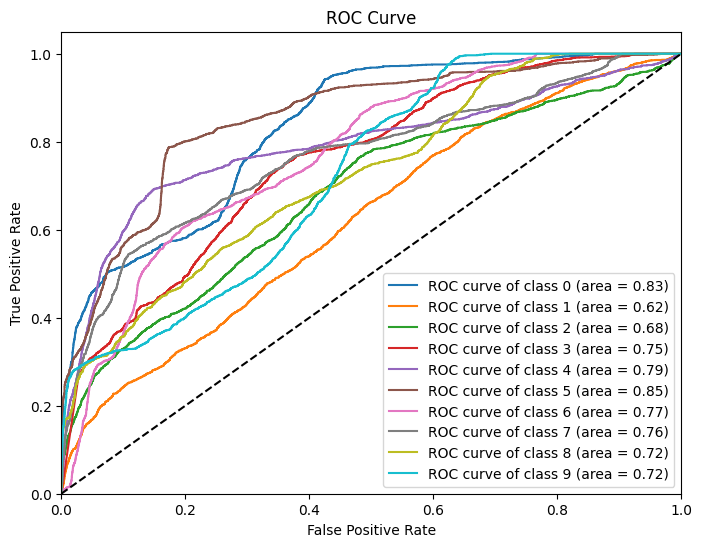

------------------------------------------------------------------------------------------------


In [35]:
print("Multinomial:")
mnb_result = runclassifier(multNB,shuffled_balanced_data_df)

---

### 2. <ins> Complement Naive Bayes

Complement:
Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.34826666666666667
Precision: 0.48259062408057635
Recall (TPR): 0.34826666666666667
False Positive Rate (FPR): 0.07241481481481493
F1 score (F-measure): 0.3016035110492734
Specificity: 0.9275851851851851
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.869822   0.397648      0.586222  0.098667              0.473864   
1      1  0.899289   0.414894      0.017333  0.002716              0.033276   
2      2  0.855911   0.324238      0.406667  0.094173              0.360804   
3      3  0.807778   0.231565      0.397778  0.146667              0.292723   
4      4  0.890489   0.457708      0.514667  0.067753              0.484519   
5      5  0.762533   0.285417      0.914222  0.254321              0.435022   
6      6  0.902222   1.000000      0.022222  0.000000              0.043478   
7      7  0.901378   0.520476      0.175111  0.017926              0.262055   
8      8  0.911822   0.734982      0.184889  0.007407              0.295455   
9      9  0.895289   0.458978      0.263556  0.034519              0.334839   

     TP    FP     TN    FN  
0  1319  1998  18252   931  
1    39    55  20195  2211  
2   915  1907  18343  1335  
3   895  2970  17280  1355  
4  1158  1372  18878  1092  
5  2057  5150  15100   193  
6    50     0  20250  2200  
7   394   363  19887  1856  
8   416   150  20100  1834  
9   593   699  19551  1657

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


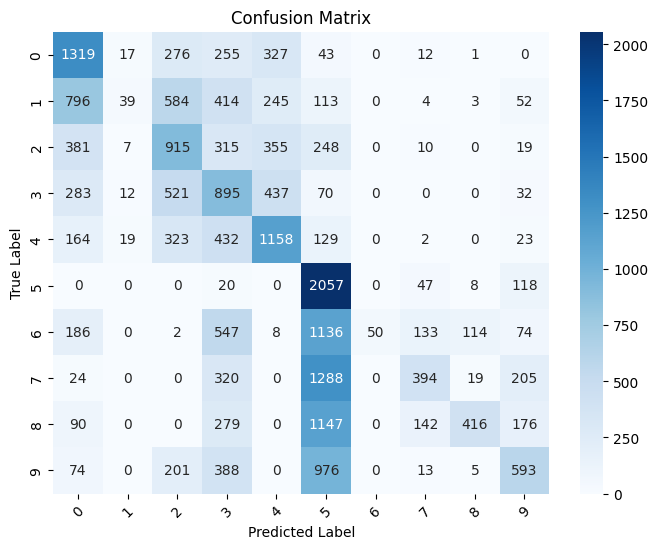

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


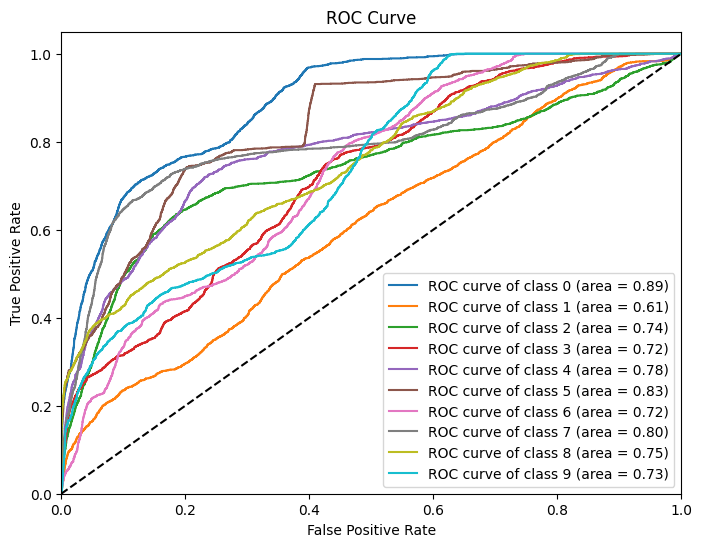

------------------------------------------------------------------------------------------------


In [36]:
print("Complement:")
cnb_result = runclassifier(compNB,shuffled_balanced_data_df)

---

### 3. <ins> Bernoulli Naive Bayes

Bernoulli:
Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.10826666666666666
Precision: 0.2514928168270303
Recall (TPR): 0.10826666666666666
False Positive Rate (FPR): 0.09908148148148155
F1 score (F-measure): 0.03409608902611946
Specificity: 0.9009185185185185
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.109200   0.100929      1.000000  0.989778              0.183352   
1      1  0.900000   0.000000      0.000000  0.000000              0.000000   
2      2  0.900000   0.000000      0.000000  0.000000              0.000000   
3      3  0.900267   0.666667      0.005333  0.000296              0.010582   
4      4  0.901244   0.769231      0.017778  0.000593              0.034752   
5      5  0.905822   0.978102      0.059556  0.000148              0.112275   
6      6  0.900000   0.000000      0.000000  0.000000              0.000000   
7      7  0.900000   0.000000      0.000000  0.000000              0.000000   
8      8  0.900000   0.000000      0.000000  0.000000              0.000000   
9      9  0.900000   0.000000      0.000000  0.000000              0.000000   

     TP     FP     TN    FN  
0  2250  20043    207     0  
1     0      0  20250  2250  
2     0      0  20250  2250  
3    12      6  20244  2238  
4    40     12  20238  2210  
5   134      3  20247  2116  
6     0      0  20250  2250  
7     0      0  20250  2250  
8     0      0  20250  2250  
9     0      0  20250  2250

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


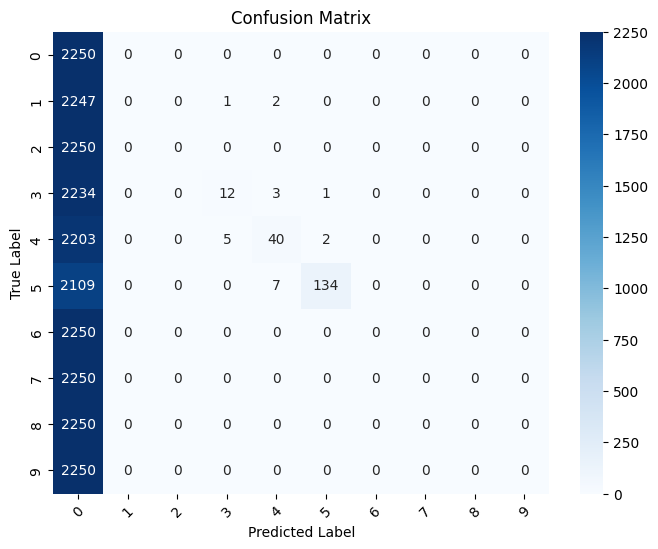

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


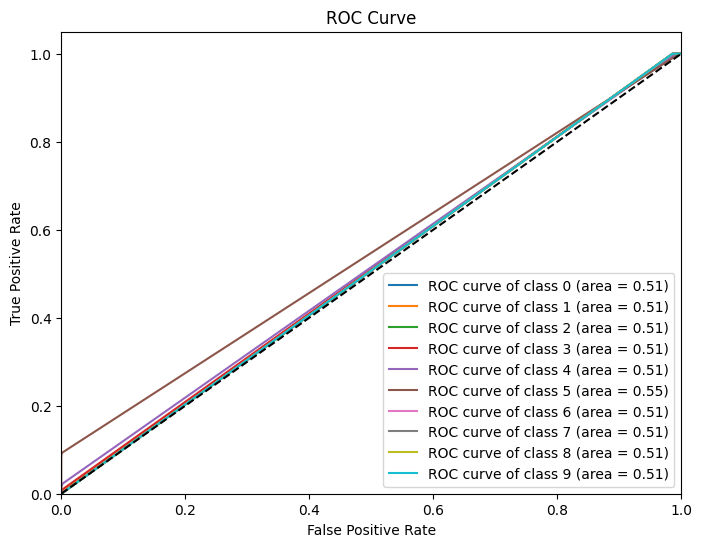

------------------------------------------------------------------------------------------------


In [37]:
print("Bernoulli:")
bnb_result = runclassifier(bernNB,shuffled_balanced_data_df)

---

## <ins> Feature Selection

#### Selection of the Top 20, 10 and 5 features from the shuffled and balanced dataset

In [38]:
data = shuffled_balanced_data_df #load the data

- #### To select the features for particular class x, the label of class x is set to 0 and the rest of the labels are set to 1
- #### Correlation matrix is then run on the modified data set
- #### The absolute value of the correlation is taken to give equal priority to a high negative correlation and a high positive correlation
- #### Top 20 features are returned out of which top 10 and 5 are choosen for their respective dataframes

In [ ]:
data1=data.copy()
replacement_dict = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} # differentiating class 0 from other classes
data1['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes expect class 0 to 1
corr_matrix = data1.corr()
print("--------------------------")
print("Top 20 features of class 0")
print("---------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 0
print("------------------------------------")
print("5 least reliable features of class 0")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 0

In [ ]:
data2=data.copy()
replacement_dict = {0 : 1,1 : 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} # differentiating class 1 from other classes
data2['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 1 to 0 and rest to 1
corr_matrix = data2.corr()
print("--------------------------")
print("Top 20 features of class 1")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 1
print("------------------------------------")
print("5 least reliable features of class 1")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 1

In [ ]:
data3=data.copy()
replacement_dict = {0 : 1,2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} # differentiating class 2 from other classes
data3['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 2 to 0 and rest to 1
corr_matrix = data3.corr()
print("----------------------------")
print("Top 20 features of class 2")
print("----------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 2
print("------------------------------------")
print("5 least reliable features of class 2")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 2

In [ ]:
data4=data.copy()
replacement_dict = {0 : 1,2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} # differentiating class 3 from other classes
data4['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 3 to 0 and rest to 1
corr_matrix = data4.corr()
print("--------------------------")
print("Top 20 features of class 3")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 3
print("------------------------------------")
print("5 least reliable features of class 3")
print("------------------------------------")
corr_matrix['label'].abs().sort_values(ascending=True).head(5) #getting the least reliable 5 features for class 3

In [ ]:
data5=data.copy()
replacement_dict = {0 : 1,2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} # differentiating class 4 from other classes
data5['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 4 to 0 and rest to 1
corr_matrix = data5.corr()
print("--------------------------")
print("Top 20 features of class 4")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 4
print("------------------------------------")
print("5 least reliable features of class 4")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 4

In [ ]:
data6=data.copy()
replacement_dict = {0 : 1,2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1} # differentiating class 5 from other classes
data6['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 5 to 0 and rest to 1
corr_matrix = data6.corr()
print("--------------------------")
print("Top 20 features of class 5")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 5
print("------------------------------------")
print("5 least reliable features of class 5")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 5

In [ ]:
data7=data.copy()
replacement_dict = {0 : 1,2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1} # differentiating class 6 from other classes
data7['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 6 to 0 and rest to 1
corr_matrix = data7.corr()
print("--------------------------")
print("Top 20 features of class 6")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 6
print("------------------------------------")
print("5 least reliable features of class 6")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 6

In [ ]:
data8=data.copy()
replacement_dict = {0 : 1,2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1} # differentiating class 7 from other classes
data8['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 7 to 0 and rest to 1
corr_matrix = data8.corr()
print("--------------------------")
print("Top 20 features of class 7")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 7
print("------------------------------------")
print("5 least reliable features of class 7")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 7

In [ ]:
data9=data.copy()
replacement_dict = {0 : 1,2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1} # differentiating class 8 from other classes
data6['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 8 to 0 and rest to 1
corr_matrix = data9.corr()
print("--------------------------")
print("Top 20 features of class 8")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 8
print("------------------------------------")
print("5 least reliable features of class 8")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 8

In [ ]:
data10=data.copy()
replacement_dict = {0 : 1,2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0} # differentiating class 9 from other classes
data10['label'] = data['label'].replace(replacement_dict) # changing the target label of all classes class 9 to 0 and rest to 1
corr_matrix = data10.corr()
print("--------------------------")
print("Top 20 features of class 9")
print("--------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=False).head(21)) #getting the top 20 features for class 9
print("------------------------------------")
print("5 least reliable features of class 9")
print("------------------------------------")
print(corr_matrix['label'].abs().sort_values(ascending=True).head(5)) #getting the least reliable 5 features for class 9

---

### <ins> Datasets of Top 20, Top 10 and Top 5 features

In [39]:
top5= data[[1121,1979,1168,1169,1978,1073,1168,1120,1215,1263,795,1316,1311,796,843,1171,1172,1219,1414,1220,1713,1695,1666,1696,1714,1508,1460,1461,1507,1509,841,792,793,840,1181,1468,1507,1469,1176,1420,1667,1714,1715,1666,1174,1561,1610,1562,1609,510,'label']]
top5 = top5.loc[:, ~top5.columns.duplicated()] #removing duplicate features

In [40]:
top10= data[[1121, 1979, 1168, 1169, 1978, 1980, 1930, 1931, 1120, 2027, 1073, 1168, 1120, 1215, 1263, 1216, 1167, 1121, 1072, 1264, 795, 1316, 1311, 796, 843, 1263, 1312, 844, 1135, 1264, 1171, 1172, 1219, 1414, 1220, 1567, 1519, 1568, 1471, 1520, 1713, 1695, 1666, 1696, 1714, 1647, 1694, 1744, 1743, 1760, 1508, 1460, 1461, 1507, 1509, 1459, 1462, 1506, 1564, 1510, 841, 792, 793, 840, 1181, 1604, 1365, 1605, 791, 744, 1468, 1507, 1469, 1176, 1420, 1419, 1459, 1506, 1517, 1460, 1667, 1714, 1715, 1666, 1174, 1173, 1126, 1471, 1713, 1472, 1561, 1610, 1562, 1609, 510, 509, 508, 560, 458, 559,'label']]
top10 = top10.loc[:, ~top10.columns.duplicated()] #removing duplicate features

In [41]:
top20= data[[1121, 1979, 1168, 1169, 1978, 1980, 1930, 1931, 1120, 2027, 2028, 1319, 2263, 2026, 1122, 2262, 1977, 2029, 2264, 1073, 1073, 1168, 1120, 1215, 1263, 1216, 1167, 1121, 1072, 1264, 1311, 1025, 1310, 1074, 1262, 1026, 1119, 1214, 740, 1312, 795, 1316, 1311, 796, 843, 1263, 1312, 844, 1135, 1264, 1281, 1315, 794, 1232, 1183, 1184, 1329, 1086, 1330, 747, 1171, 1172, 1219, 1414, 1220, 1567, 1519, 1568, 1471, 1520, 1553, 1221, 1601, 1648, 1470, 1518, 1415, 1218, 1696, 1649, 1713, 1695, 1666, 1696, 1714, 1647, 1694, 1744, 1743, 1760, 1665, 1646, 1648, 1761, 1712, 1745, 983, 1697, 1030, 1742, 1508, 1460, 1461, 1507, 1509, 1459, 1462, 1506, 1564, 1510, 1458, 1130, 1516, 1612, 1556, 1555, 1320, 1420, 1412, 1468, 1742, 841, 792, 793, 840, 1181, 1604, 1365, 1605, 791, 744, 1133, 1229, 842, 889, 794, 1364, 745, 743, 1652, 839, 1468, 1507, 1469, 1176, 1420, 1419, 1459, 1506, 1517, 1460, 1458, 1508, 1224, 1128, 1371, 1505, 1518, 1516, 1470, 1555, 1667, 1714, 1715, 1666, 1174, 1173, 1126, 1471, 1713, 1472, 1222, 1221, 1762, 1125, 1078, 1743, 1761, 1695, 1520, 1694, 1561, 1610, 1562, 1609, 510, 509, 508, 560, 458, 559, 1134, 459, 511, 558, 1611, 507, 457, 1182, 456, 460,'label']]
top20 = top20.loc[:, ~top20.columns.duplicated()] #removing duplicate features

---

###  <ins> Dataset of Least 5 reliable features

In [42]:
least5 = data[[362, 75, 938, 1555, 412, 986, 1807, 1741, 982, 1667, 2153, 540, 908, 2204, 1639, 257, 1395, 1060, 268, 1393, 1036, 1659, 1564, 938, 1188, 1860, 2045, 1500, 1231, 1356, 1419, 1468, 1467, 1516, 1371, 1545, 1702, 2038, 495, 496, 935, 1305, 1839, 634, 2280, 1237, 1996, 1991, 1674, 2117]]
least5 = least5.loc[:, ~least5.columns.duplicated()]

---

## <ins> Running Classifiers on Top 20 Features </ins>

### 1. <ins> Multinomial Naive Bayes

Multinomial:
------------------------------------------------------------------------------------------------
Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.6152888888888889
Precision: 0.6249739048377021
Recall (TPR): 0.6152888888888889
False Positive Rate (FPR): 0.042745679012345716
F1 score (F-measure): 0.6121812669533883
Specificity: 0.9572543209876543
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.931511   0.663590      0.639111  0.036000              0.651121   
1      1  0.909022   0.565442      0.389778  0.033284              0.461458   
2      2  0.900489   0.502422      0.507111  0.055802              0.504756   
3      3  0.886578   0.422959      0.368444  0.055852              0.393824   
4      4  0.900933   0.502944      0.797333  0.087556              0.616813   
5      5  0.962978   0.825747      0.798222  0.018716              0.811751   
6      6  0.953600   0.883100      0.617778  0.009086              0.726987   
7      7  0.956133   0.753716      0.833778  0.030272              0.791728   
8      8  0.931156   0.639032      0.716000  0.044938              0.675330   
9      9  0.898178   0.490787      0.485333  0.055951              0.488045   

     TP    FP     TN    FN  
0  1438   729  19521   812  
1   877   674  19576  1373  
2  1141  1130  19120  1109  
3   829  1131  19119  1421  
4  1794  1773  18477   456  
5  1796   379  19871   454  
6  1390   184  20066   860  
7  1876   613  19637   374  
8  1611   910  19340   639  
9  1092  1133  19117  1158

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


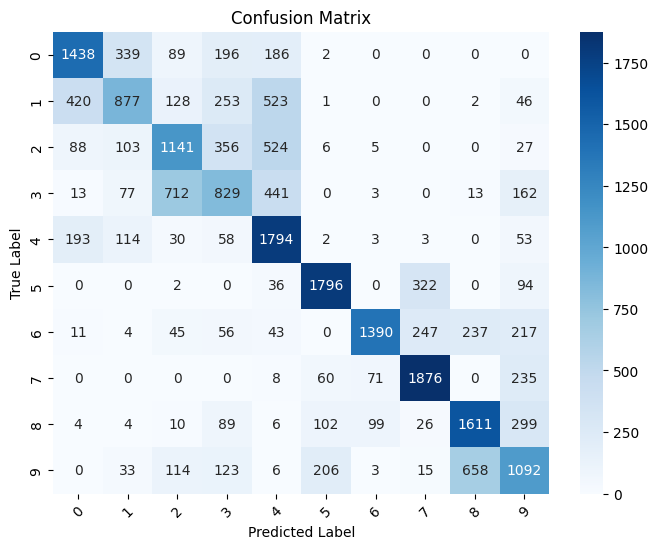

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


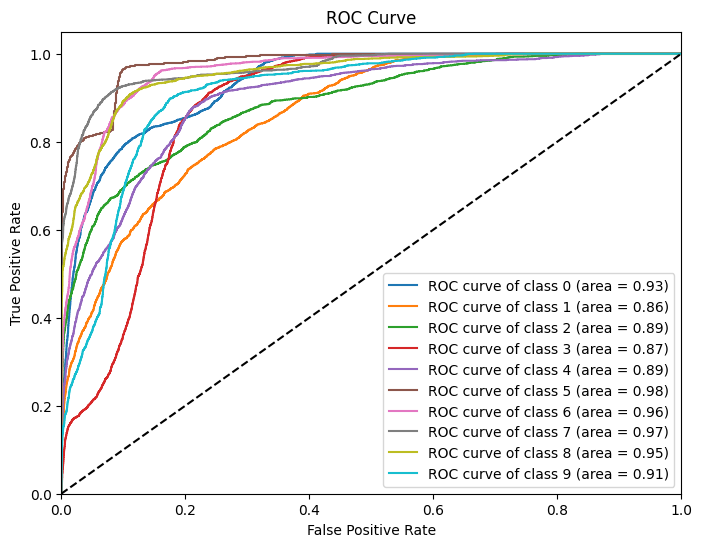

------------------------------------------------------------------------------------------------


In [43]:
data = top20
print("Multinomial:")
print("------------------------------------------------------------------------------------------------")
multNB_result = runclassifier(multNB,data)


---

### 2. <ins> Gaussian Naive Bayes

Gaussian:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.5140444444444444
Precision: 0.5501358571199406
Recall (TPR): 0.5140444444444444
False Positive Rate (FPR): 0.053995061728394966
F1 score (F-measure): 0.47959632943341524
Specificity: 0.946004938271605
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.920622   0.572956      0.809778  0.067062              0.671087   
1      1  0.885511   0.392622      0.264889  0.045531              0.316348   
2      2  0.907067   0.557318      0.343556  0.030321              0.425076   
3      3  0.847511   0.368280      0.733778  0.139852              0.490420   
4      4  0.897200   0.350711      0.032889  0.006765              0.060138   
5      5  0.930578   0.959893      0.319111  0.001481              0.478986   
6      6  0.881111   0.447544      0.805778  0.110519              0.575464   
7      7  0.905911   0.539607      0.402667  0.038173              0.461186   
8      8  0.940044   0.773196      0.566667  0.018469              0.654014   
9      9  0.912533   0.539232      0.861333  0.081778              0.663244   

     TP    FP     TN    FN  
0  1822  1358  18892   428  
1   596   922  19328  1654  
2   773   614  19636  1477  
3  1651  2832  17418   599  
4    74   137  20113  2176  
5   718    30  20220  1532  
6  1813  2238  18012   437  
7   906   773  19477  1344  
8  1275   374  19876   975  
9  1938  1656  18594   312

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


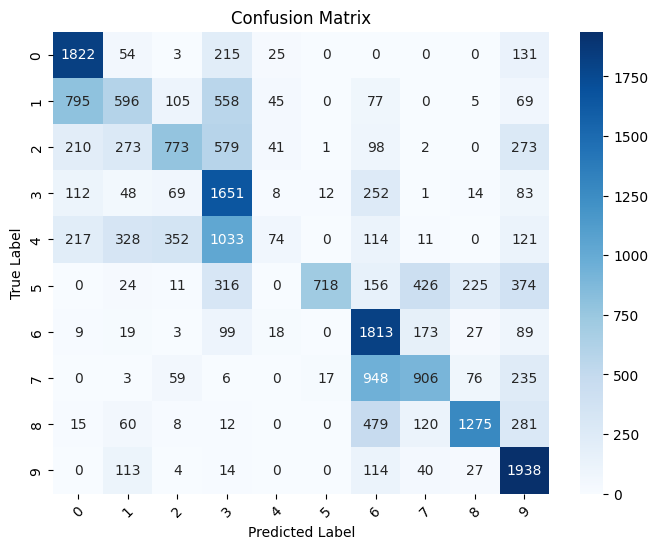

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


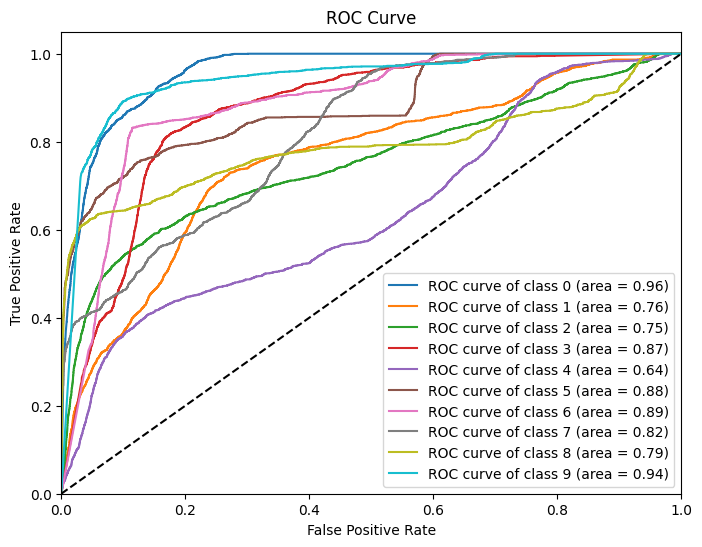

------------------------------------------------------------------------------------------------


In [44]:
print("Gaussian:")
print("------------------------------------------------------------------------------------------------")
GNB_result = runclassifier(GNB,data)

---

### 3. <ins> Compliment Naive Bayes

Compliment:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.4872444444444444
Precision: 0.5639509889523543
Recall (TPR): 0.4872444444444444
False Positive Rate (FPR): 0.05697283950617282
F1 score (F-measure): 0.42348394005373735
Specificity: 0.9430271604938272
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.803511   0.331103      0.945778  0.212296              0.490492   
1      1  0.907022   0.632997      0.167111  0.010765              0.264416   
2      2  0.908000   0.555970      0.397333  0.035259              0.463453   
3      3  0.899911   0.375000      0.001333  0.000247              0.002657   
4      4  0.899511   0.497898      0.579111  0.064889              0.535443   
5      5  0.966222   0.902268      0.742667  0.008938              0.814725   
6      6  0.901022   0.896552      0.011556  0.000148              0.022817   
7      7  0.880222   0.452366      0.939111  0.126321              0.610605   
8      8  0.929333   0.617021      0.773333  0.053333              0.686391   
9      9  0.879733   0.378335      0.315111  0.057531              0.343841   

     TP    FP     TN    FN  
0  2128  4299  15951   122  
1   376   218  20032  1874  
2   894   714  19536  1356  
3     3     5  20245  2247  
4  1303  1314  18936   947  
5  1671   181  20069   579  
6    26     3  20247  2224  
7  2113  2558  17692   137  
8  1740  1080  19170   510  
9   709  1165  19085  1541

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


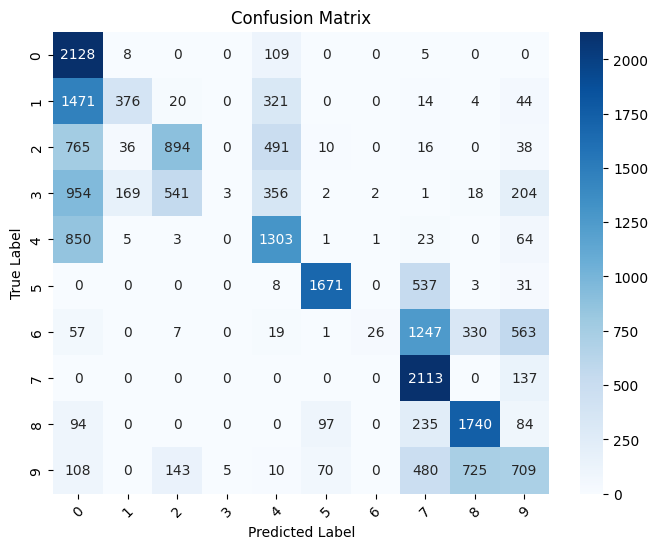

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


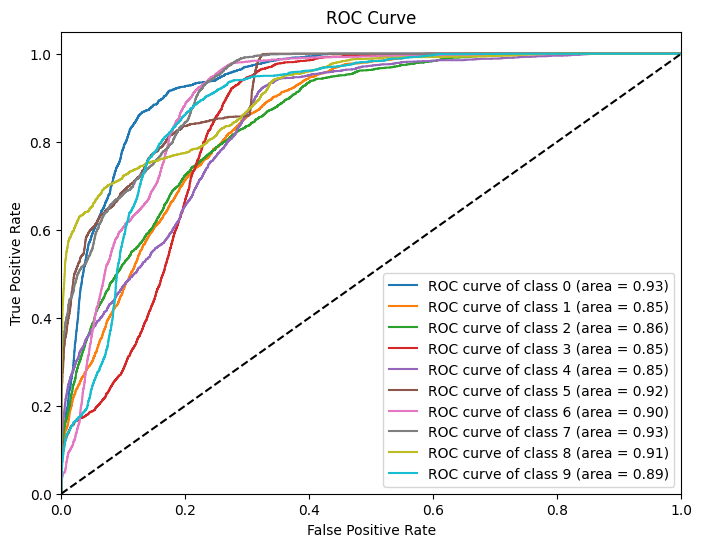

------------------------------------------------------------------------------------------------


In [45]:
print("Compliment:")
print("------------------------------------------------------------------------------------------------")
comp_result = runclassifier(compNB,data)


---

### 4. <ins> Bernoulli Naive Bayes

Bernoulli:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.10608888888888889
Precision: 0.29390748378240145
Recall (TPR): 0.10608888888888889
False Positive Rate (FPR): 0.09932345679012344
F1 score (F-measure): 0.03073716513775812
Specificity: 0.9006765432098766
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.108400   0.100561      0.996444  0.990272              0.182685   
1      1  0.900000   0.000000      0.000000  0.000000              0.000000   
2      2  0.900000   0.000000      0.000000  0.000000              0.000000   
3      3  0.900400   0.800000      0.005333  0.000148              0.010596   
4      4  0.901200   0.935484      0.012889  0.000099              0.025427   
5      5  0.904133   0.969697      0.042667  0.000148              0.081737   
6      6  0.898044   0.133333      0.003556  0.002568              0.006926   
7      7  0.900000   0.000000      0.000000  0.000000              0.000000   
8      8  0.900000   0.000000      0.000000  0.000000              0.000000   
9      9  0.900000   0.000000      0.000000  0.000000              0.000000   

     TP     FP     TN    FN  
0  2242  20053    197     8  
1     0      0  20250  2250  
2     0      0  20250  2250  
3    12      3  20247  2238  
4    29      2  20248  2221  
5    96      3  20247  2154  
6     8     52  20198  2242  
7     0      0  20250  2250  
8     0      0  20250  2250  
9     0      0  20250  2250

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


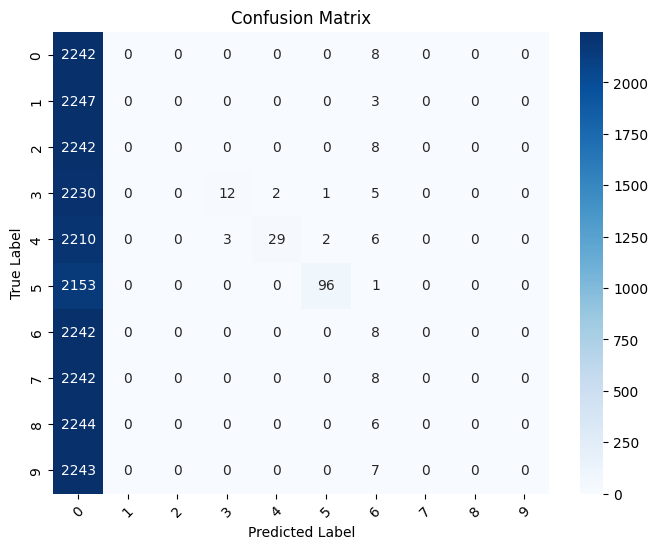

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


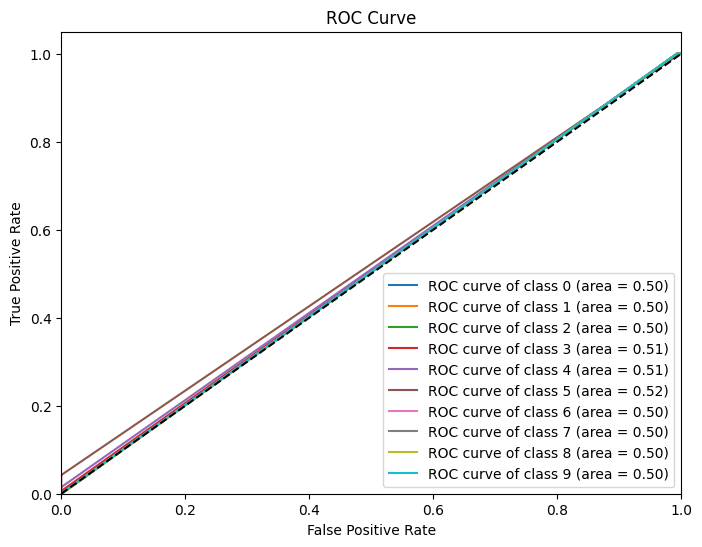

------------------------------------------------------------------------------------------------


In [46]:
print("Bernoulli:")
print("------------------------------------------------------------------------------------------------")
bern_result = runclassifier(bernNB,data)


---

### 5. <ins> Categorical Naive Bayes

Categorical:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.19444444444444445
Precision: 0.5528024795619445
Recall (TPR): 0.19444444444444445
False Positive Rate (FPR): 0.08950617283950613
F1 score (F-measure): 0.1783931551893497
Specificity: 0.9104938271604939
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.900267   0.875000      0.003111  0.000049              0.006200   
1      1  0.907689   0.680585      0.144889  0.007556              0.238915   
2      2  0.913822   0.736682      0.215111  0.008543              0.332989   
3      3  0.894356   0.350588      0.066222  0.013630              0.111402   
4      4  0.905689   0.657635      0.118667  0.006864              0.201054   
5      5  0.911822   0.816667      0.152444  0.003802              0.256929   
6      6  0.899956   0.000000      0.000000  0.000049              0.000000   
7      7  0.248089   0.115457      0.978667  0.833086              0.206547   
8      8  0.909111   0.825397      0.115556  0.002716              0.202729   
9      9  0.898089   0.470014      0.149778  0.018765              0.227165   

     TP     FP     TN    FN  
0     7      1  20249  2243  
1   326    153  20097  1924  
2   484    173  20077  1766  
3   149    276  19974  2101  
4   267    139  20111  1983  
5   343     77  20173  1907  
6     0      1  20249  2250  
7  2202  16870   3380    48  
8   260     55  20195  1990  
9   337    380  19870  1913

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


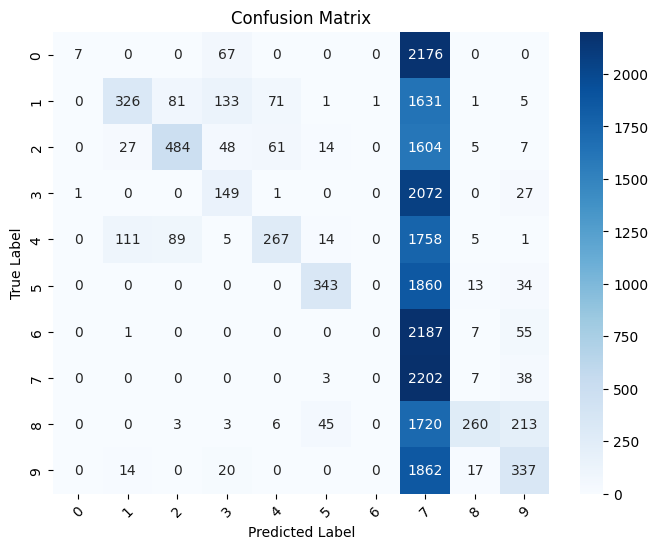

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


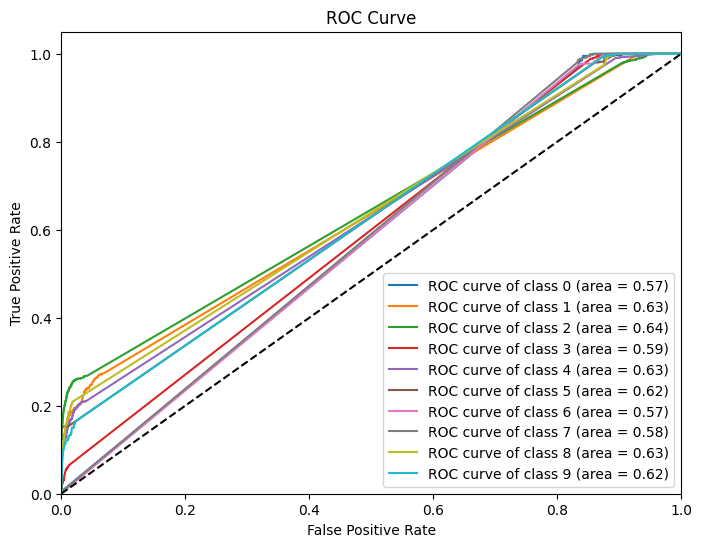

------------------------------------------------------------------------------------------------


In [47]:
print("Categorical:")
print("------------------------------------------------------------------------------------------------")
cat_result = runclassifier(catNB,data)

---

## <ins> Running Classifiers on Top 10 Features </ins>

### 1. <ins> Multinomial Naive Bayes

Multinomial:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.6186222222222222
Precision: 0.6249576794404954
Recall (TPR): 0.6186222222222222
False Positive Rate (FPR): 0.04237530864197525
F1 score (F-measure): 0.6151790311334685
Specificity: 0.9576246913580247
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.929467   0.658234      0.612889  0.035358              0.634753   
1      1  0.899289   0.495465      0.388444  0.043951              0.435476   
2      2  0.907822   0.542025      0.504444  0.047358              0.522560   
3      3  0.886622   0.424105      0.373778  0.056395              0.397354   
4      4  0.907733   0.525043      0.810667  0.081481              0.637317   
5      5  0.972489   0.855958      0.871556  0.016296              0.863686   
6      6  0.952089   0.872774      0.609778  0.009877              0.717949   
7      7  0.957022   0.760032      0.833333  0.029235              0.794997   
8      8  0.930578   0.643813      0.684444  0.042074              0.663507   
9      9  0.894133   0.472128      0.496889  0.061728              0.484192   

     TP    FP     TN    FN  
0  1379   716  19534   871  
1   874   890  19360  1376  
2  1135   959  19291  1115  
3   841  1142  19108  1409  
4  1824  1650  18600   426  
5  1961   330  19920   289  
6  1372   200  20050   878  
7  1875   592  19658   375  
8  1540   852  19398   710  
9  1118  1250  19000  1132

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


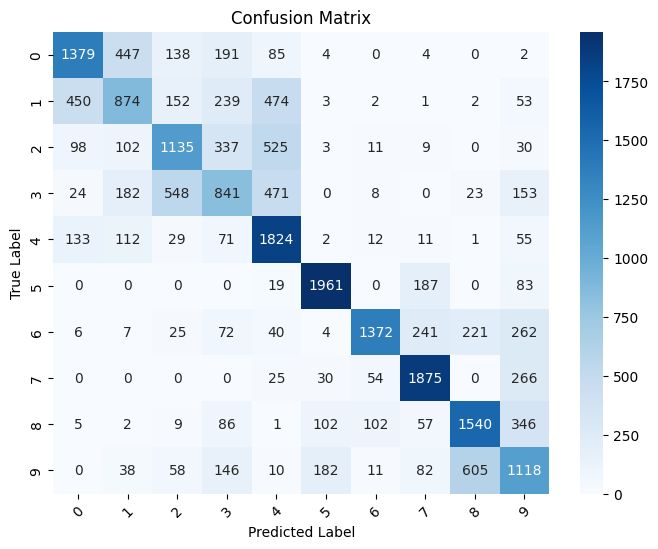

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


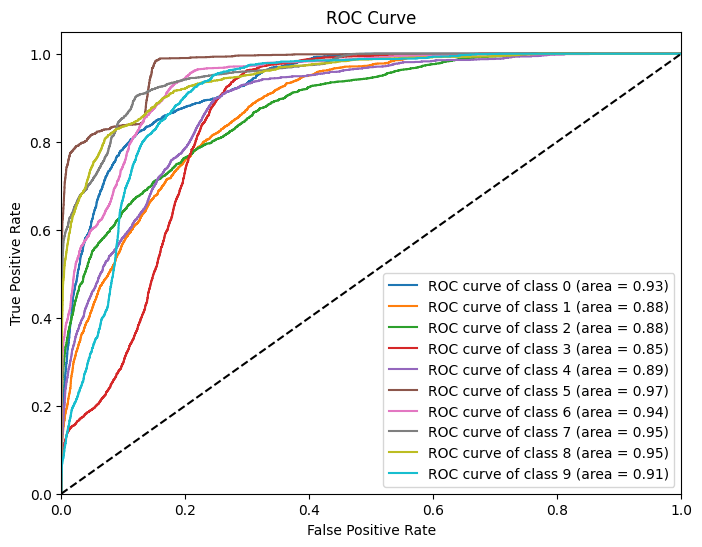

------------------------------------------------------------------------------------------------


In [48]:
data = top10
print("Multinomial:")
print("------------------------------------------------------------------------------------------------")
multNB_result1=runclassifier(multNB,data)


### 2. <ins> Gaussian Naive Bayes

Gaussian:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.5087111111111111
Precision: 0.5558133809694857
Recall (TPR): 0.5087111111111111
False Positive Rate (FPR): 0.054587654320987666
F1 score (F-measure): 0.47996081018954606
Specificity: 0.9454123456790123
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.912178   0.541340      0.797333  0.075062              0.644860   
1      1  0.886844   0.398769      0.259111  0.043407              0.314116   
2      2  0.900444   0.503943      0.284000  0.031062              0.363275   
3      3  0.825422   0.341159      0.800889  0.171852              0.478492   
4      4  0.898889   0.422360      0.030222  0.004593              0.056408   
5      5  0.942133   0.967456      0.436000  0.001630              0.601103   
6      6  0.886133   0.450128      0.625778  0.084938              0.523615   
7      7  0.909156   0.561091      0.420444  0.036543              0.480691   
8      8  0.946311   0.841415      0.570667  0.011951              0.680085   
9      9  0.909911   0.530473      0.862667  0.084840              0.656964   

     TP    FP     TN    FN  
0  1794  1520  18730   456  
1   583   879  19371  1667  
2   639   629  19621  1611  
3  1802  3480  16770   448  
4    68    93  20157  2182  
5   981    33  20217  1269  
6  1408  1720  18530   842  
7   946   740  19510  1304  
8  1284   242  20008   966  
9  1941  1718  18532   309

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


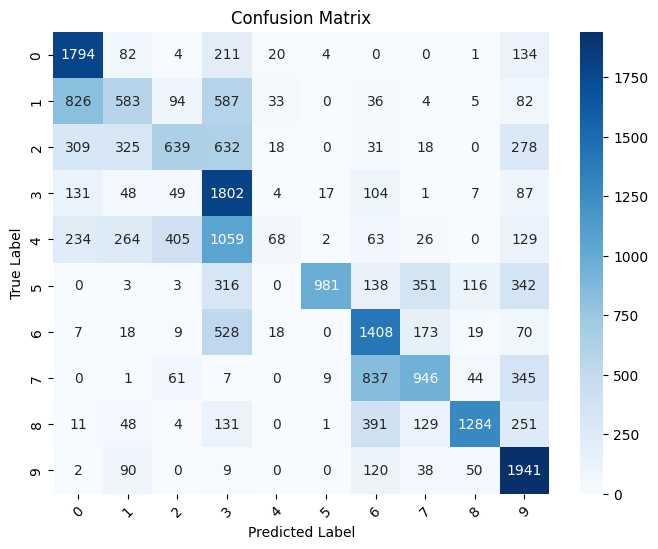

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


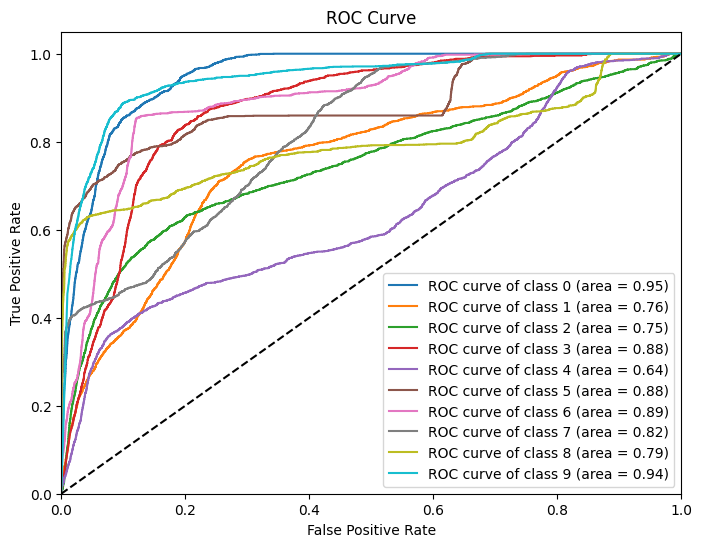

------------------------------------------------------------------------------------------------


In [49]:
print("Gaussian:")
print("------------------------------------------------------------------------------------------------")
GNB_result1 = runclassifier(GNB,data)


---

### 3. <ins> Compliment Naive Bayes

Compliment:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.48484444444444447
Precision: 0.5316337719286971
Recall (TPR): 0.48484444444444447
False Positive Rate (FPR): 0.05723950617283946
F1 score (F-measure): 0.42110129214688885
Specificity: 0.9427604938271605
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.794978   0.316907      0.908889  0.217679              0.469953   
1      1  0.891778   0.401700      0.168000  0.027802              0.236916   
2      2  0.910844   0.603741      0.315556  0.023012              0.414478   
3      3  0.898800   0.186047      0.003556  0.001728              0.006978   
4      4  0.904400   0.519824      0.576889  0.059210              0.546872   
5      5  0.978400   0.950920      0.826667  0.004741              0.884451   
6      6  0.901022   0.896552      0.011556  0.000148              0.022817   
7      7  0.879067   0.449755      0.936889  0.127358              0.607756   
8      8  0.925333   0.592834      0.808889  0.061728              0.684211   
9      9  0.885067   0.398058      0.291556  0.048988              0.336583   

     TP    FP     TN    FN  
0  2045  4408  15842   205  
1   378   563  19687  1872  
2   710   466  19784  1540  
3     8    35  20215  2242  
4  1298  1199  19051   952  
5  1860    96  20154   390  
6    26     3  20247  2224  
7  2108  2579  17671   142  
8  1820  1250  19000   430  
9   656   992  19258  1594

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


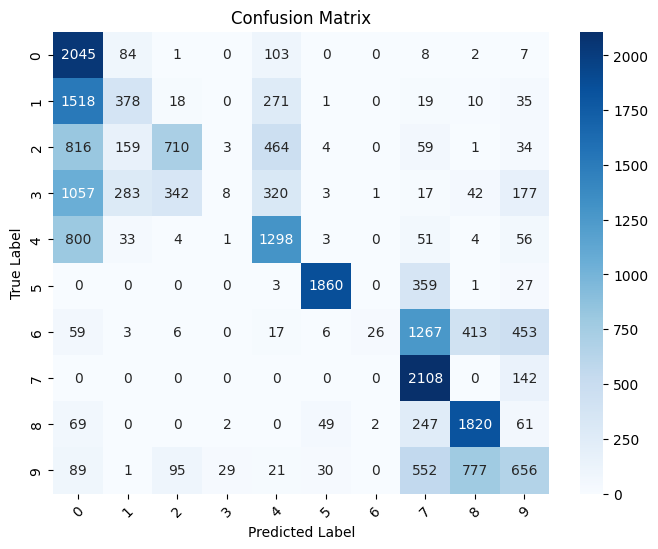

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


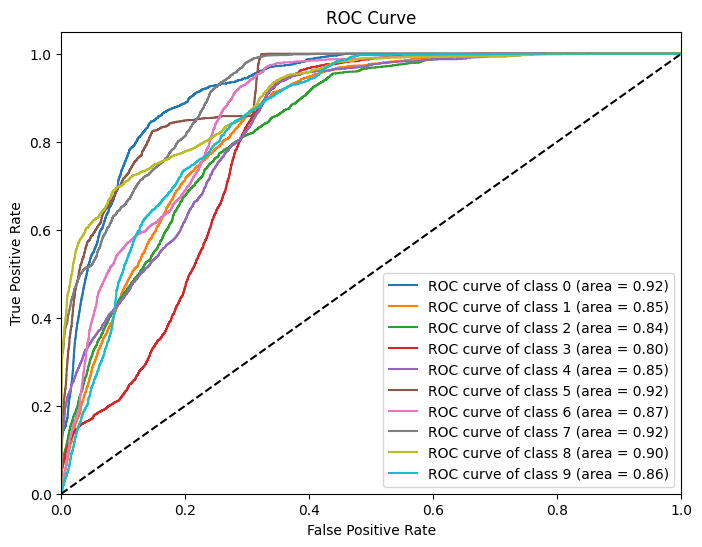

------------------------------------------------------------------------------------------------


In [50]:
print("Compliment:")
print("------------------------------------------------------------------------------------------------")
comp_result1 = runclassifier(compNB,data)


---

### 4. <ins> Bernoulli Naive Bayes

Bernoulli:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.10551111111111111
Precision: 0.3045803297753096
Recall (TPR): 0.10551111111111111
False Positive Rate (FPR): 0.0993876543209875
F1 score (F-measure): 0.02959631679564242
Specificity: 0.9006123456790125
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.107733   0.100493      0.996444  0.991012              0.182573   
1      1  0.900000   0.000000      0.000000  0.000000              0.000000   
2      2  0.900000   0.000000      0.000000  0.000000              0.000000   
3      3  0.900356   0.900000      0.004000  0.000049              0.007965   
4      4  0.900844   0.952381      0.008889  0.000049              0.017613   
5      5  0.904044   0.959596      0.042222  0.000198              0.080885   
6      6  0.898044   0.133333      0.003556  0.002568              0.006926   
7      7  0.900000   0.000000      0.000000  0.000000              0.000000   
8      8  0.900000   0.000000      0.000000  0.000000              0.000000   
9      9  0.900000   0.000000      0.000000  0.000000              0.000000   

     TP     FP     TN    FN  
0  2242  20068    182     8  
1     0      0  20250  2250  
2     0      0  20250  2250  
3     9      1  20249  2241  
4    20      1  20249  2230  
5    95      4  20246  2155  
6     8     52  20198  2242  
7     0      0  20250  2250  
8     0      0  20250  2250  
9     0      0  20250  2250

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


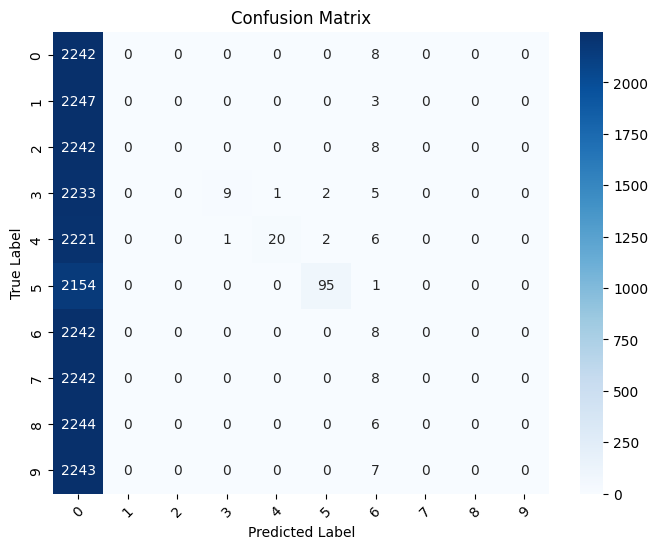

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


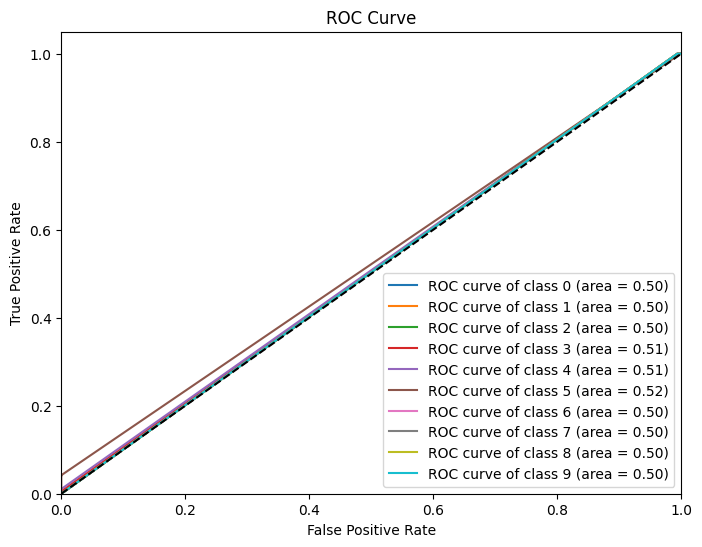

------------------------------------------------------------------------------------------------


In [51]:
print("Bernoulli:")
print("------------------------------------------------------------------------------------------------")
bern_result1 = runclassifier(bernNB,data)


---

### 5. <ins> Categorical Naive Bayes

Categorical:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.1903111111111111
Precision: 0.48053726028271987
Recall (TPR): 0.1903111111111111
False Positive Rate (FPR): 0.0899654320987654
F1 score (F-measure): 0.17098720980239027
Specificity: 0.9100345679012346
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.900000   0.000000      0.000000  0.000000              0.000000   
1      1  0.908000   0.704545      0.137778  0.006420              0.230483   
2      2  0.912622   0.713213      0.211111  0.009432              0.325789   
3      3  0.897289   0.406728      0.059111  0.009580              0.103221   
4      4  0.903911   0.600457      0.116889  0.008642              0.195685   
5      5  0.911556   0.805164      0.152444  0.004099              0.256353   
6      6  0.900000   0.000000      0.000000  0.000000              0.000000   
7      7  0.239422   0.114968      0.986222  0.843556              0.205930   
8      8  0.908444   0.970297      0.087111  0.000296              0.159869   
9      9  0.899378   0.490000      0.152444  0.017630              0.232542   

     TP     FP     TN    FN  
0     0      0  20250  2250  
1   310    130  20120  1940  
2   475    191  20059  1775  
3   133    194  20056  2117  
4   263    175  20075  1987  
5   343     83  20167  1907  
6     0      0  20250  2250  
7  2219  17082   3168    31  
8   196      6  20244  2054  
9   343    357  19893  1907

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


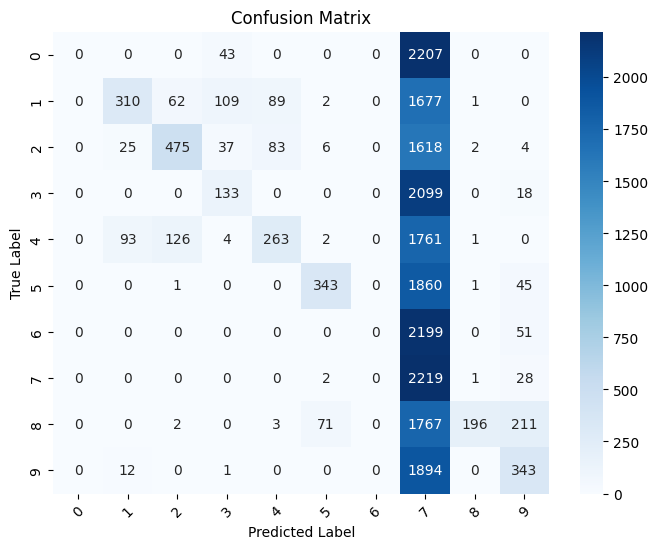

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


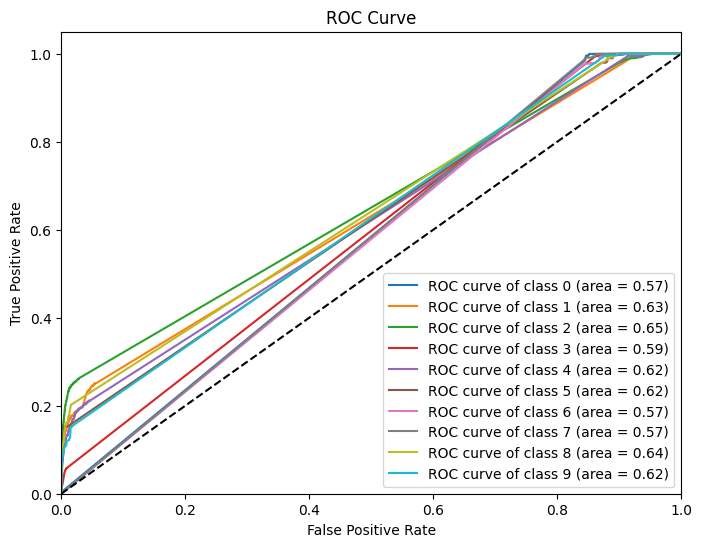

------------------------------------------------------------------------------------------------


In [52]:
print("Categorical:")
print("------------------------------------------------------------------------------------------------")
cat_result1 = runclassifier(catNB,data)

---

## <ins> Running Classifiers on Top 5 Features </ins>

### 1. <ins> Multinomial Naive Bayes

Multinomial:
------------------------------------------------------------------------------------------------
Overall Metrics


------------------------------------------------------------------------------------------------
Accuracy: 0.6568444444444445
Precision: 0.6625766993219796
Recall (TPR): 0.6568444444444445
False Positive Rate (FPR): 0.03812839506172838
F1 score (F-measure): 0.6541714116684128
Specificity: 0.9618716049382716
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.936222   0.692854      0.650667  0.032049              0.671098   
1      1  0.899467   0.497263      0.484444  0.054420              0.490770   
2      2  0.923111   0.639037      0.531111  0.033333              0.580097   
3      3  0.904444   0.527533      0.425778  0.042370              0.471225   
4      4  0.910622   0.534055      0.832889  0.080741              0.650807   
5      5  0.969867   0.870755      0.820444  0.013531              0.844851   
6      6  0.956622   0.834208      0.706667  0.015605              0.765159   
7      7  0.964622   0.802917      0.856444  0.023358              0.828817   
8      8  0.937644   0.665236      0.757778  0.042370              0.708498   
9      9  0.911067   0.561909      0.502222  0.043506              0.530392   

     TP    FP     TN    FN  
0  1464   649  19601   786  
1  1090  1102  19148  1160  
2  1195   675  19575  1055  
3   958   858  19392  1292  
4  1874  1635  18615   376  
5  1846   274  19976   404  
6  1590   316  19934   660  
7  1927   473  19777   323  
8  1705   858  19392   545  
9  1130   881  19369  1120

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


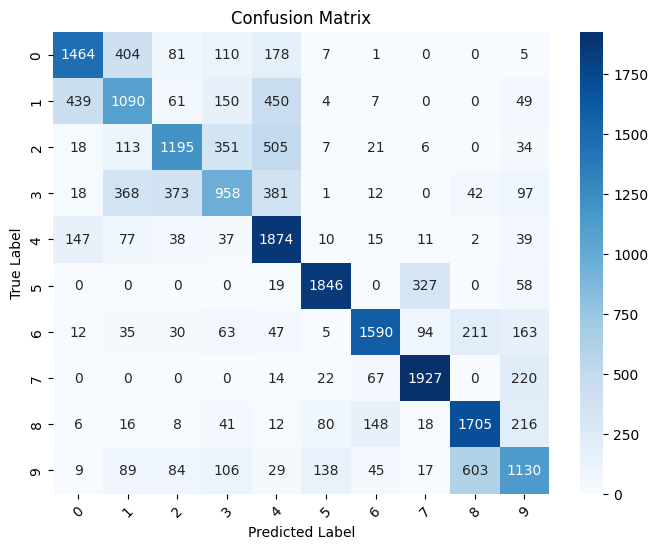

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


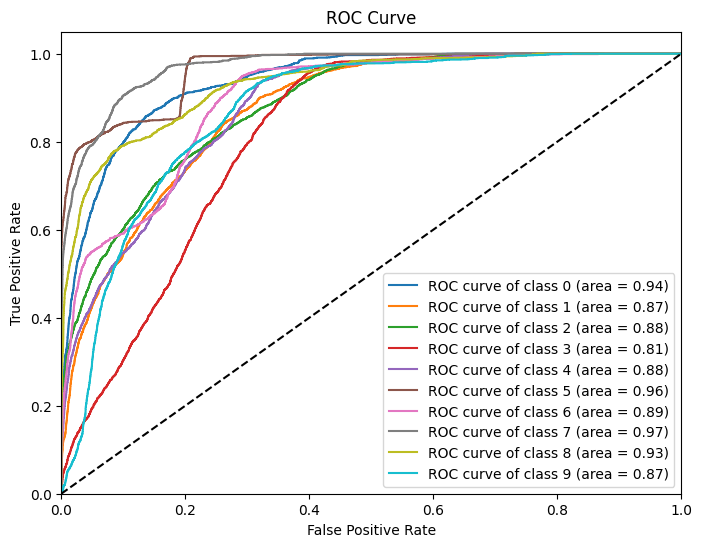

------------------------------------------------------------------------------------------------


In [53]:
data = top5
print("Multinomial:")
print("------------------------------------------------------------------------------------------------")
multNB_result2=runclassifier(multNB,data)


---

### 2. <ins> Gaussian Naive Bayes

Gaussian:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.5228
Precision: 0.5986130928167351
Recall (TPR): 0.5228
False Positive Rate (FPR): 0.05302222222222208
F1 score (F-measure): 0.49620132011767154
Specificity: 0.9469777777777779
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.906000   0.519628      0.794222  0.081580              0.628230   
1      1  0.882844   0.376282      0.260889  0.048049              0.308136   
2      2  0.910400   0.601916      0.307111  0.022568              0.406710   
3      3  0.843511   0.367411      0.782667  0.149728              0.500071   
4      4  0.903467   0.705263      0.059556  0.002765              0.109836   
5      5  0.944578   0.961362      0.464444  0.002074              0.626311   
6      6  0.885644   0.454926      0.724444  0.096444              0.558889   
7      7  0.920444   0.661972      0.417778  0.023704              0.512262   
8      8  0.944800   0.825581      0.568000  0.013333              0.672986   
9      9  0.903911   0.511790      0.848889  0.089975              0.638582   

     TP    FP     TN    FN  
0  1787  1652  18598   463  
1   587   973  19277  1663  
2   691   457  19793  1559  
3  1761  3032  17218   489  
4   134    56  20194  2116  
5  1045    42  20208  1205  
6  1630  1953  18297   620  
7   940   480  19770  1310  
8  1278   270  19980   972  
9  1910  1822  18428   340

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


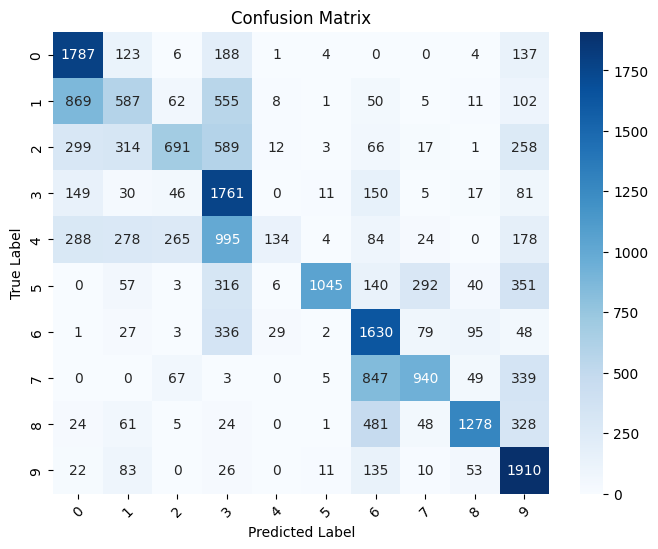

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


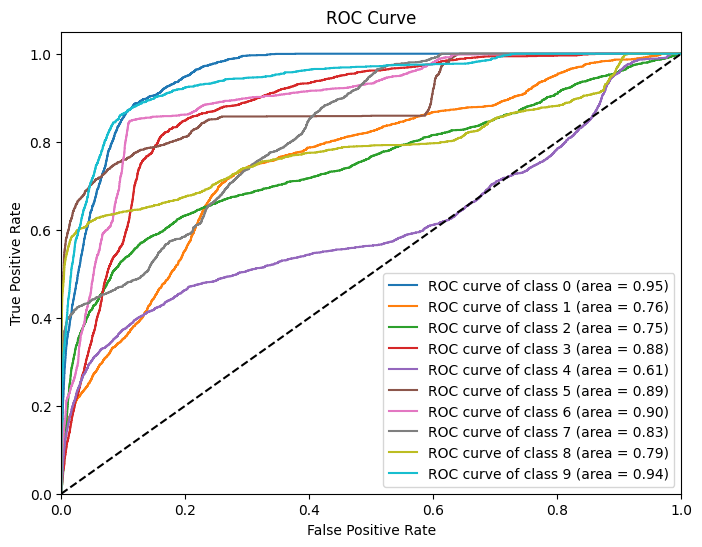

------------------------------------------------------------------------------------------------


In [54]:
print("Gaussian:")
print("------------------------------------------------------------------------------------------------")
GNB_result2 = runclassifier(GNB,data)


---

### 3. <ins> Compliment Naive Bayes

Compliment:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.4607111111111111
Precision: 0.5694729253306671
Recall (TPR): 0.4607111111111111
False Positive Rate (FPR): 0.05992098765432097
F1 score (F-measure): 0.39392584660046115
Specificity: 0.940079012345679
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.783911   0.308561      0.935556  0.232938              0.464065   
1      1  0.877511   0.288107      0.152889  0.041975              0.199768   
2      2  0.912044   0.599122      0.364000  0.027062              0.452861   
3      3  0.899867   0.475410      0.012889  0.001580              0.025097   
4      4  0.905911   0.535965      0.440444  0.042370              0.483533   
5      5  0.966578   0.936480      0.714222  0.005383              0.810388   
6      6  0.903289   1.000000      0.032889  0.000000              0.063683   
7      7  0.865511   0.426208      0.996000  0.148988              0.596963   
8      8  0.901778   0.505426      0.828000  0.090025              0.627695   
9      9  0.905022   0.619450      0.130222  0.008889              0.215204   

     TP    FP     TN    FN  
0  2105  4717  15533   145  
1   344   850  19400  1906  
2   819   548  19702  1431  
3    29    32  20218  2221  
4   991   858  19392  1259  
5  1607   109  20141   643  
6    74     0  20250  2176  
7  2241  3017  17233     9  
8  1863  1823  18427   387  
9   293   180  20070  1957

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


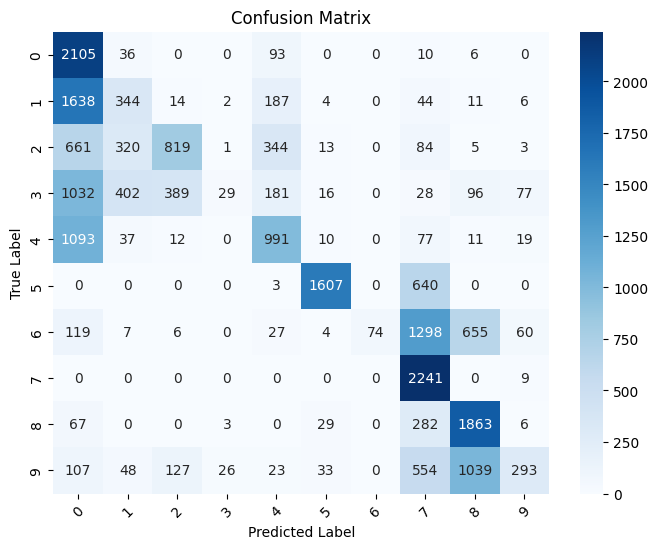

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


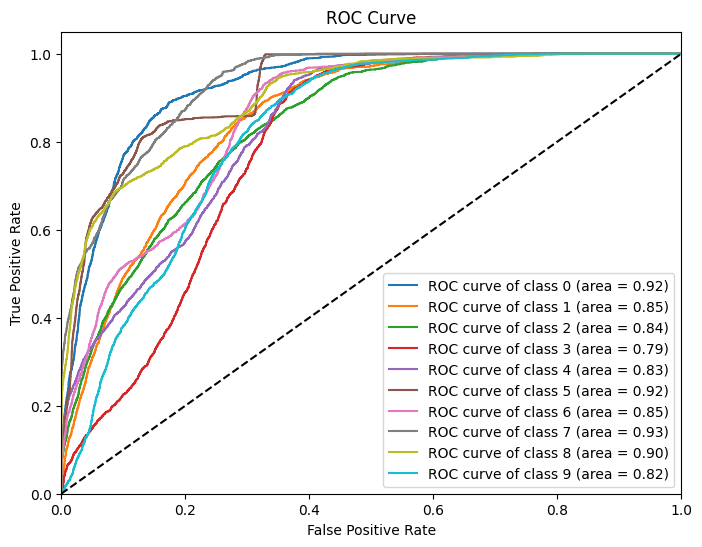

------------------------------------------------------------------------------------------------


In [55]:
print("Compliment:")
print("------------------------------------------------------------------------------------------------")
comp_result2 = runclassifier(compNB,data)


---

### 4. <ins> Bernoulli Naive Bayes

Bernoulli:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.10493333333333334
Precision: 0.30401494841334326
Recall (TPR): 0.10493333333333334
False Positive Rate (FPR): 0.09945185185185179
F1 score (F-measure): 0.028515349339772872
Specificity: 0.9005481481481482
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.107111   0.100430      0.996444  0.991704              0.182469   
1      1  0.900000   0.000000      0.000000  0.000000              0.000000   
2      2  0.900000   0.000000      0.000000  0.000000              0.000000   
3      3  0.900311   0.888889      0.003556  0.000049              0.007083   
4      4  0.900844   0.952381      0.008889  0.000049              0.017613   
5      5  0.903556   0.965116      0.036889  0.000148              0.071062   
6      6  0.898044   0.133333      0.003556  0.002568              0.006926   
7      7  0.900000   0.000000      0.000000  0.000000              0.000000   
8      8  0.900000   0.000000      0.000000  0.000000              0.000000   
9      9  0.900000   0.000000      0.000000  0.000000              0.000000   

     TP     FP     TN    FN  
0  2242  20082    168     8  
1     0      0  20250  2250  
2     0      0  20250  2250  
3     8      1  20249  2242  
4    20      1  20249  2230  
5    83      3  20247  2167  
6     8     52  20198  2242  
7     0      0  20250  2250  
8     0      0  20250  2250  
9     0      0  20250  2250

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


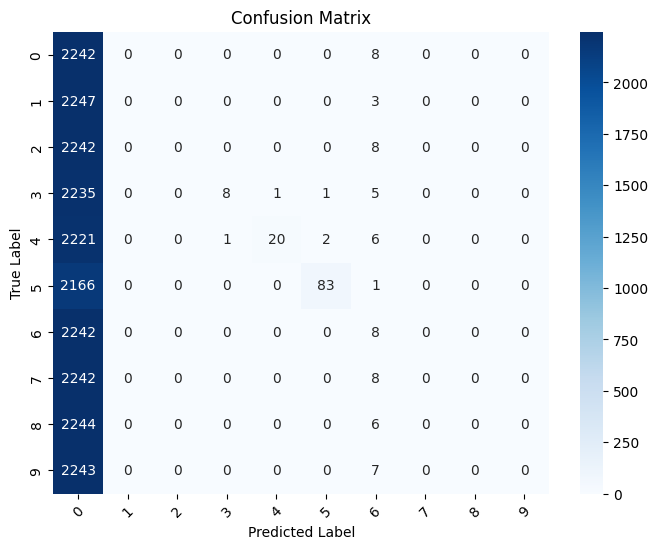

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


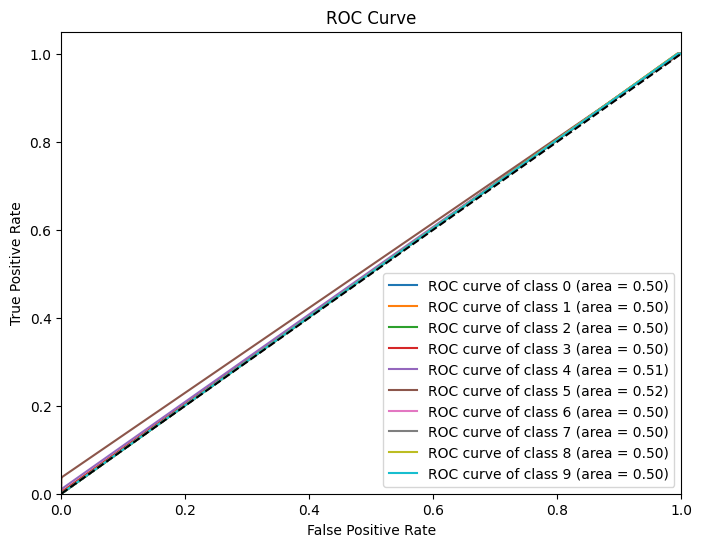

------------------------------------------------------------------------------------------------


In [56]:
print("Bernoulli:")
print("------------------------------------------------------------------------------------------------")
bern_result2 = runclassifier(bernNB,data)


---

### 5. <ins> Categorical Naive Bayes

Categorical:
------------------------------------------------------------------------------------------------


Overall Metrics
------------------------------------------------------------------------------------------------
Accuracy: 0.1847111111111111
Precision: 0.47439299148666614
Recall (TPR): 0.1847111111111111
False Positive Rate (FPR): 0.09058765432098759
F1 score (F-measure): 0.16217039932652028
Specificity: 0.9094123456790124
------------------------------------------------------------------------------------------------

Classwise Metrics:


Class  Accuracy  Precision  Recall (TPR)       FPR  F1 Score (F-measure)  \
0      0  0.900000   0.000000      0.000000  0.000000              0.000000   
1      1  0.905511   0.654229      0.116889  0.006864              0.198341   
2      2  0.912311   0.712098      0.206667  0.009284              0.320358   
3      3  0.898311   0.434028      0.055556  0.008049              0.098503   
4      4  0.902756   0.566524      0.117333  0.009975              0.194404   
5      5  0.911689   0.812352      0.152000  0.003901              0.256084   
6      6  0.900000   0.000000      0.000000  0.000000              0.000000   
7      7  0.231111   0.114616      0.994667  0.853728              0.205547   
8      8  0.908489   0.965854      0.088000  0.000346              0.161303   
9      9  0.899244   0.484230      0.116000  0.013728              0.187164   

     TP     FP     TN    FN  
0     0      0  20250  2250  
1   263    139  20111  1987  
2   465    188  20062  1785  
3   125    163  20087  2125  
4   264    202  20048  1986  
5   342     79  20171  1908  
6     0      0  20250  2250  
7  2238  17288   2962    12  
8   198      7  20243  2052  
9   261    278  19972  1989

------------------------------------------------------------------------------------------------
Confusion Matrix
------------------------------------------------------------------------------------------------


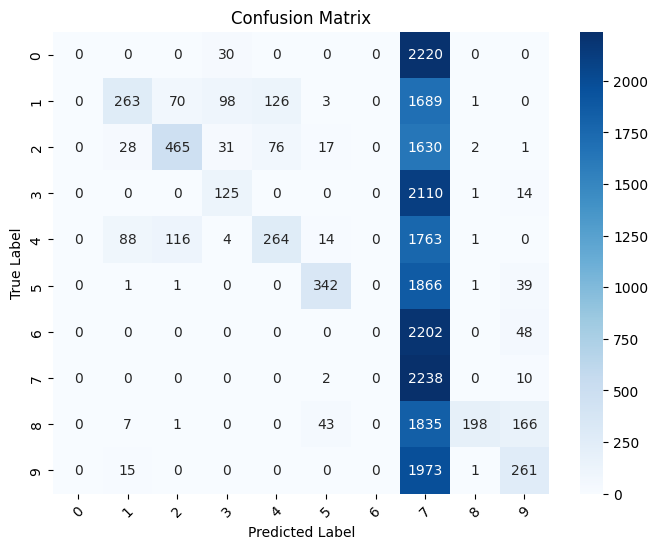

------------------------------------------------------------------------------------------------
ROC Curve
------------------------------------------------------------------------------------------------


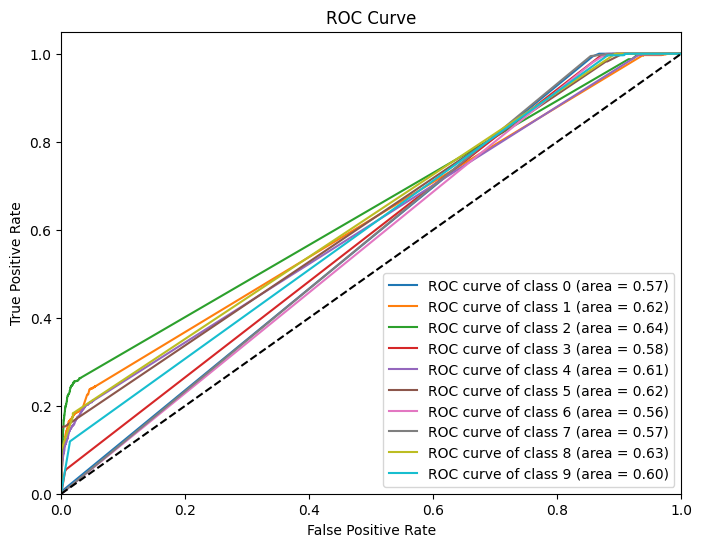

------------------------------------------------------------------------------------------------


In [57]:
print("Categorical:")
print("------------------------------------------------------------------------------------------------")
cat_result2 = runclassifier(catNB,data)

---

## <ins> Function for collecting the results

In [58]:
# DataFrame for Training Metrics
bayes_nets_results = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 score': [],
    'True Positive': [],
    'False Positive': [],
    'True Negative': [],
    'False Negative': [],
    'Sensitivity (TPR)': [],
    'Specificity': [],
    'False Positive Rate':[],
    'Features Used': [],
})

def extract_metrics(d, metric_type):
    """Extract metrics (either training or test) from the result dictionary."""
    metrics = d[metric_type]

    # Check if TP, FP, TN, FN values are lists, and if so, sum them to get scalar values
    TP = sum(metrics['TP']) if isinstance(metrics['TP'], (list, np.ndarray)) else metrics['TP']
    FP = sum(metrics['FP']) if isinstance(metrics['FP'], (list, np.ndarray)) else metrics['FP']
    TN = sum(metrics['TN']) if isinstance(metrics['TN'], (list, np.ndarray)) else metrics['TN']
    FN = sum(metrics['FN']) if isinstance(metrics['FN'], (list, np.ndarray)) else metrics['FN']

    return [
        d['Model'],
        metrics['Accuracy'],
        metrics['Precision'],
        metrics['Recall'],
        metrics['F1 score'],
        TP,
        FP,
        TN,
        FN,
        metrics['Sensitivity (TPR)'],
        metrics['Specificity'],
        metrics['FPR']
    ]


datasets = [
    (mnb_result, "Complete"),
    (gnb_result, "Complete"),
    (cnb_result, "Complete"),
    (bnb_result, "Complete"),
    (multNB_result, "Top 20"),
    (GNB_result, "Top 20"),
    (comp_result, "Top 20"),
    (bern_result, "Top 20"),
    (cat_result, "Top 20"),
    (multNB_result1, "Top 10"),
    (GNB_result1, "Top 10"),
    (comp_result1, "Top 10"),
    (bern_result1, "Top 10"),
    (cat_result1, "Top 10"),
    (multNB_result2, "Top 5"),
    (GNB_result2, "Top 5"),
    (comp_result2, "Top 5"),
    (bern_result2, "Top 5"),
    (cat_result2, "Top 5")
]

for d, data_val in datasets:
    bayes_nets_results.loc[len(bayes_nets_results.index)] = extract_metrics(d, "Training Metrics") + [data_val]


---

## <ins> Overall Results

In [59]:
bayes_nets_results

Model  Accuracy  Precision    Recall  F1 score  True Positive  \
0   MultinomialNB  0.371511   0.381931  0.371511  0.352207           8359   
1      GaussianNB  0.343467   0.388641  0.343467  0.325461           7728   
2    ComplementNB  0.348267   0.482591  0.348267  0.301604           7836   
3     BernoulliNB  0.108267   0.251493  0.108267  0.034096           2436   
4   MultinomialNB  0.615289   0.624974  0.615289  0.612181          13844   
5      GaussianNB  0.514044   0.550136  0.514044  0.479596          11566   
6    ComplementNB  0.487244   0.563951  0.487244  0.423484          10963   
7     BernoulliNB  0.106089   0.293907  0.106089  0.030737           2387   
8   CategoricalNB  0.194444   0.552802  0.194444  0.178393           4375   
9   MultinomialNB  0.618622   0.624958  0.618622  0.615179          13919   
10     GaussianNB  0.508711   0.555813  0.508711  0.479961          11446   
11   ComplementNB  0.484844   0.531634  0.484844  0.421101          10909   
12    BernoulliNB  0.105511   0.304580  0.105511  0.029596           2374   
13  CategoricalNB  0.190311   0.480537  0.190311  0.170987           4282   
14  MultinomialNB  0.656844   0.662577  0.656844  0.654171          14779   
15     GaussianNB  0.522800   0.598613  0.522800  0.496201          11763   
16   ComplementNB  0.460711   0.569473  0.460711  0.393926          10366   
17    BernoulliNB  0.104933   0.304015  0.104933  0.028515           2361   
18  CategoricalNB  0.184711   0.474393  0.184711  0.162170           4156   

    False Positive  True Negative  False Negative  Sensitivity (TPR)  \
0            14141         188359           14141           0.371511   
1            14772         187728           14772           0.343467   
2            14664         187836           14664           0.348267   
3            20064         182436           20064           0.108267   
4             8656         193844            8656           0.615289   
5            10934         191566           10934           0.514044   
6            11537         190963           11537           0.487244   
7            20113         182387           20113           0.106089   
8            18125         184375           18125           0.194444   
9             8581         193919            8581           0.618622   
10           11054         191446           11054           0.508711   
11           11591         190909           11591           0.484844   
12           20126         182374           20126           0.105511   
13           18218         184282           18218           0.190311   
14            7721         194779            7721           0.656844   
15           10737         191763           10737           0.522800   
16           12134         190366           12134           0.460711   
17           20139         182361           20139           0.104933   
18           18344         184156           18344           0.184711   

    Specificity  False Positive Rate Features Used  
0      0.930168             0.069832      Complete  
1      0.927052             0.072948      Complete  
2      0.927585             0.072415      Complete  
3      0.900919             0.099081      Complete  
4      0.957254             0.042746        Top 20  
5      0.946005             0.053995        Top 20  
6      0.943027             0.056973        Top 20  
7      0.900677             0.099323        Top 20  
8      0.910494             0.089506        Top 20  
9      0.957625             0.042375        Top 10  
10     0.945412             0.054588        Top 10  
11     0.942760             0.057240        Top 10  
12     0.900612             0.099388        Top 10  
13     0.910035             0.089965        Top 10  
14     0.961872             0.038128         Top 5  
15     0.946978             0.053022         Top 5  
16     0.940079             0.059921         Top 5  
17     0.900548             0.099452         Top 5  
18     0.909412        

### <ins> Models sorted by F1 score

In [61]:
# get the information about the models in descending order of F1 score
bayes_results_sorted = bayes_nets_results.sort_values(by=['F1 score'], ascending=False)
bayes_results_sorted

Model  Accuracy  Precision    Recall  F1 score  True Positive  \
14  MultinomialNB  0.656844   0.662577  0.656844  0.654171          14779   
9   MultinomialNB  0.618622   0.624958  0.618622  0.615179          13919   
4   MultinomialNB  0.615289   0.624974  0.615289  0.612181          13844   
15     GaussianNB  0.522800   0.598613  0.522800  0.496201          11763   
10     GaussianNB  0.508711   0.555813  0.508711  0.479961          11446   
5      GaussianNB  0.514044   0.550136  0.514044  0.479596          11566   
6    ComplementNB  0.487244   0.563951  0.487244  0.423484          10963   
11   ComplementNB  0.484844   0.531634  0.484844  0.421101          10909   
16   ComplementNB  0.460711   0.569473  0.460711  0.393926          10366   
0   MultinomialNB  0.371511   0.381931  0.371511  0.352207           8359   
1      GaussianNB  0.343467   0.388641  0.343467  0.325461           7728   
2    ComplementNB  0.348267   0.482591  0.348267  0.301604           7836   
8   CategoricalNB  0.194444   0.552802  0.194444  0.178393           4375   
13  CategoricalNB  0.190311   0.480537  0.190311  0.170987           4282   
18  CategoricalNB  0.184711   0.474393  0.184711  0.162170           4156   
3     BernoulliNB  0.108267   0.251493  0.108267  0.034096           2436   
7     BernoulliNB  0.106089   0.293907  0.106089  0.030737           2387   
12    BernoulliNB  0.105511   0.304580  0.105511  0.029596           2374   
17    BernoulliNB  0.104933   0.304015  0.104933  0.028515           2361   

    False Positive  True Negative  False Negative  Sensitivity (TPR)  \
14            7721         194779            7721           0.656844   
9             8581         193919            8581           0.618622   
4             8656         193844            8656           0.615289   
15           10737         191763           10737           0.522800   
10           11054         191446           11054           0.508711   
5            10934         191566           10934           0.514044   
6            11537         190963           11537           0.487244   
11           11591         190909           11591           0.484844   
16           12134         190366           12134           0.460711   
0            14141         188359           14141           0.371511   
1            14772         187728           14772           0.343467   
2            14664         187836           14664           0.348267   
8            18125         184375           18125           0.194444   
13           18218         184282           18218           0.190311   
18           18344         184156           18344           0.184711   
3            20064         182436           20064           0.108267   
7            20113         182387           20113           0.106089   
12           20126         182374           20126           0.105511   
17           20139         182361           20139           0.104933   

    Specificity  False Positive Rate Features Used  
14     0.961872             0.038128         Top 5  
9      0.957625             0.042375        Top 10  
4      0.957254             0.042746        Top 20  
15     0.946978             0.053022         Top 5  
10     0.945412             0.054588        Top 10  
5      0.946005             0.053995        Top 20  
6      0.943027             0.056973        Top 20  
11     0.942760             0.057240        Top 10  
16     0.940079             0.059921         Top 5  
0      0.930168             0.069832      Complete  
1      0.927052             0.072948      Complete  
2      0.927585             0.072415      Complete  
8      0.910494             0.089506        Top 20  
13     0.910035             0.089965        Top 10  
18     0.909412             0.090588         Top 5  
3      0.900919             0.099081      Complete  
7      0.900677             0.099323        Top 20  
12     0.900612             0.099388        Top 10  
17     0.900548        

### <ins> Observations

- Compared to the classifiers' performance on the complete selection, we observed implementing feature selection improved the performance across all metrics.
- Generally, classifiers performed better on the top 5 features than the top 10 features and better than the top 20 features.
- As observed from the results, Multinomial classifier is the best performing Naive Bayes classifier on the basis of F1-score.
- Categorical and Bernoulli Naive Bayes Classifier performed poorly on our dataset since our dataset is not suited to the algorithms on which these classifiers are based on. (Our data is not categorical or binary).


---

## <ins> Visualizing the results </ins>

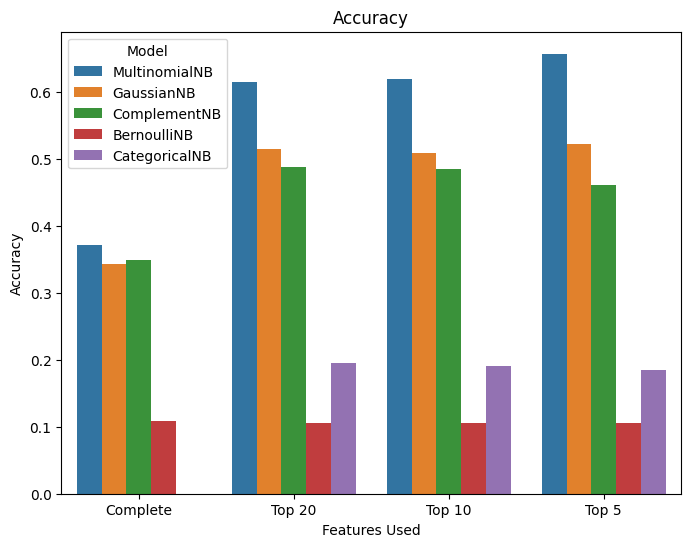

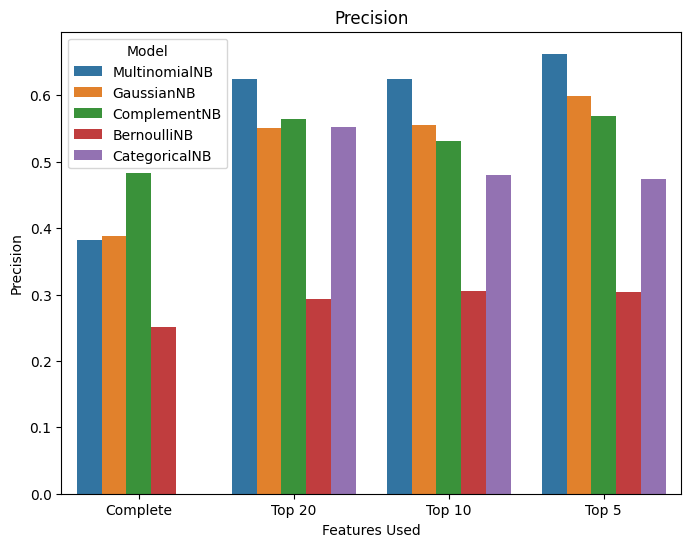

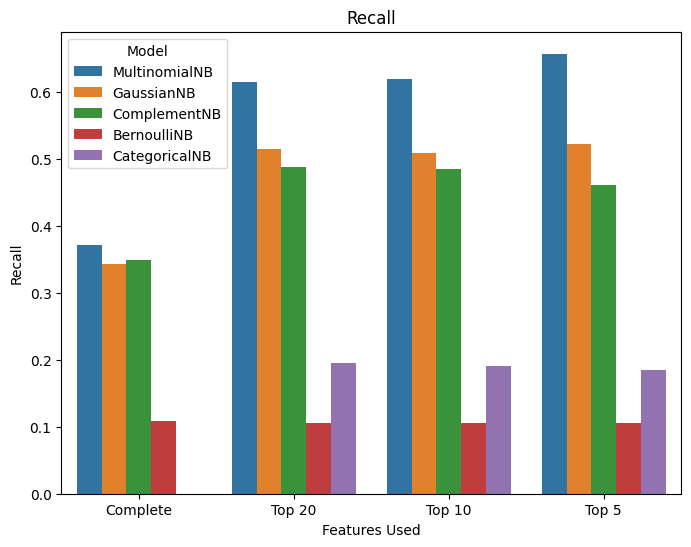

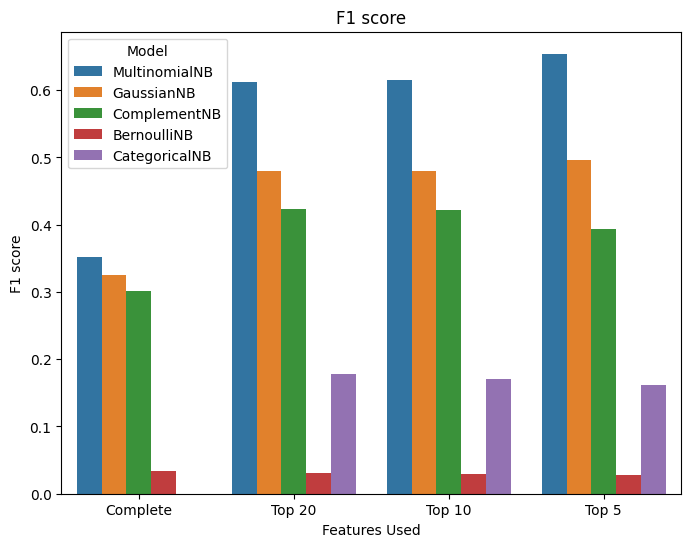

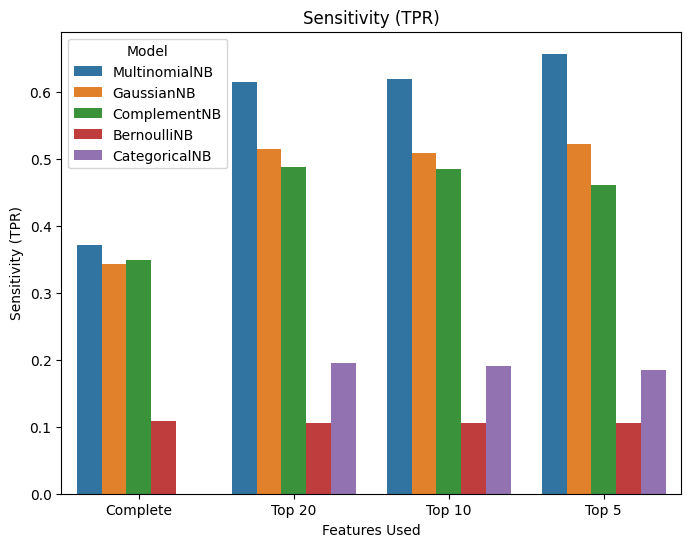

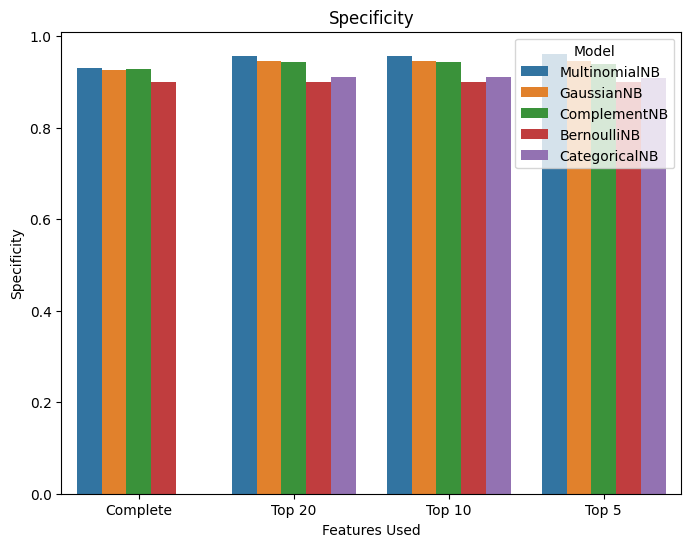

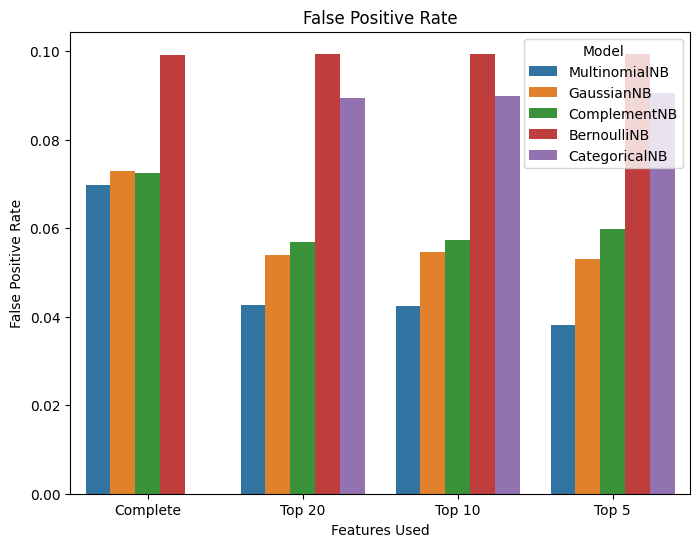

In [62]:
# Plot the metrics
def plot_metrics(df, metric, title):
    plt.figure(figsize=(8,6))
    sns.barplot(x='Features Used', y=metric, hue='Model', data=df)
    plt.title(title)
    plt.show()

plot_metrics(bayes_nets_results, 'Accuracy', 'Accuracy')
plot_metrics(bayes_nets_results, 'Precision', 'Precision')
plot_metrics(bayes_nets_results, 'Recall', 'Recall')
plot_metrics(bayes_nets_results, 'F1 score', 'F1 score')
plot_metrics(bayes_nets_results, 'Sensitivity (TPR)', 'Sensitivity (TPR)')
plot_metrics(bayes_nets_results, 'Specificity', 'Specificity')
plot_metrics(bayes_nets_results, 'False Positive Rate', 'False Positive Rate')



## <ins> Observations

- Bernoulli Naive Bayes has the lowest scores across all metrics except False Positive Rate because it predicts a single label for most values.
- Complement Naive Bayes has the highest precision on Original balanced dataset.
- Multinomial, Gaussian and Complement Naive Bayes perform similarly across all evaluation metrics (excep pricisiom, complement does better) on the original balanced dataset. The separation in performance startes to show when we use feature selection (Multinomial outperforms the rest).

---

## <ins> Final Conclusions </ins>

- In the analysis of image data comprising 2304 features, corresponding to a 48x48 pixel grid with pixel values ranging from 0 to 255, the **Multinomial Naive Bayes classifier** emerged as the optimal choice among several classifiers tested, with F1 scores as high as **0.65** on the *Top 5 features* dataset.
- This outcome can be attributed to the effective discretization of pixel values, treating them as discrete categories, and leveraging the inherent frequency representation of Multinomial Naive Bayes.
- The independence assumption of the classifier, which is reasonable for pixel values within an image, further contributes to its success in this context. Notably, this approach aligns with the classifier's typical application in text classification, where words are represented as frequency counts.
- This result underscores the versatility of Multinomial Naive Bayes when creatively adapted for image data through feature engineering.

---